# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
# 基本的なライブラリ
import os
from tqdm import tqdm

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import cumulative_dynamic_auc, concordance_index_ipcw

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

/home/breast-cancer-analytics/notebooks/functions.py:196: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:198: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [2]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [3]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [19]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [103]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    display(_X_train.shape, _y_train.shape)
    display(_X_test.shape, _y_test.shape)

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-indexスコアの表示
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    # 累積AUCの表示
    _risk_test = _model_pipeline.predict(_X_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    cph_auc, cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    plt.subplot(1, 3, 1)
    plt.plot(va_times, cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(_X_test.iloc[:1])
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(_X_test.iloc[:1])
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )

    df_score = pd.DataFrame(
        [_train_score, _test_score, cph_mean_auc],
        index=["train c-index", "test c-index", "AUC mean"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

In [110]:
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            print("subgroup: ", subgroup)
            # init each loop
            plt.figure(figsize=(18, 4))
            df_scores = pd.DataFrame(
                index=["train c-index", "test c-index", "AUC mean"]
            )
            for model_order_dict in model_order_dicts:
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                df_score = validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_pipe_path=output_pipe_path,
                    is_fitted=False,
                )
                df_scores = pd.merge(
                    df_scores, df_score, right_index=True, left_index=True
                )
            display(pd.DataFrame(df_scores))
            output_fig_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            functions.make_dir(output_fig_path)
            plt.title(subgroup)
            plt.savefig(output_fig_path + "/auc.png")
            plt.show()

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
80
subgroup:  claudin-low


(177, 105)

(177,)

(20, 105)

(20,)

(177, 105)

(177,)

(20, 105)

(20,)

(177, 105)

(177,)

(20, 105)

(20,)

(177, 105)

(177,)

(20, 105)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.889   
test c-index                                           0.629   
AUC mean                                               0.596   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.528                 0.618   
AUC mean                                  0.499                 0.627   

               ExtraSurvivalTrees  
train c-index               0.929  
test c-index                0.607  
AUC mean                    0.613

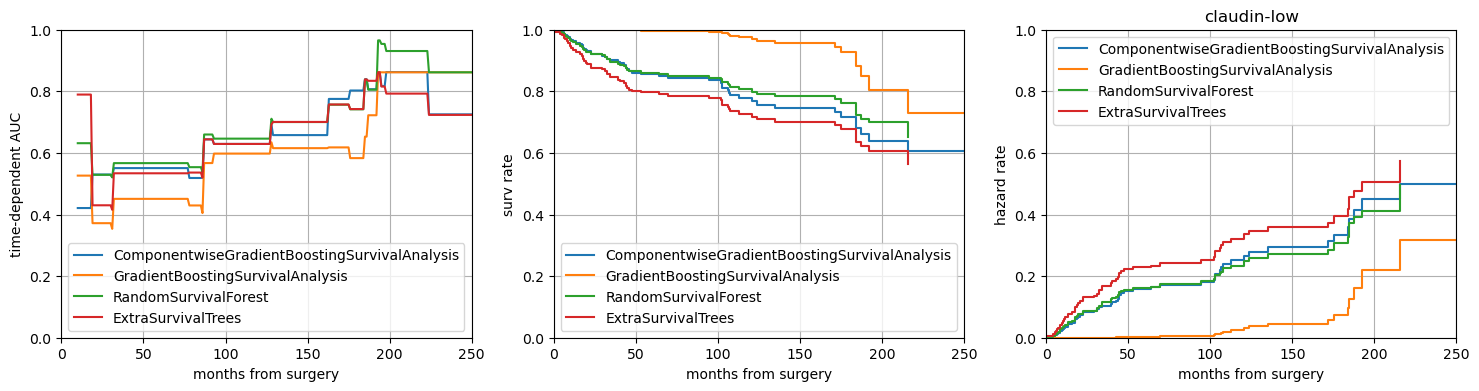

subgroup:  LumA


(605, 341)

(605,)

(68, 341)

(68,)

(605, 341)

(605,)

(68, 341)

(68,)

(605, 341)

(605,)

(68, 341)

(68,)

(605, 341)

(605,)

(68, 341)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.805   
test c-index                                           0.580   
AUC mean                                               0.635   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.997                 0.947   
test c-index                              0.410                 0.536   
AUC mean                                  0.417                 0.575   

               ExtraSurvivalTrees  
train c-index               0.959  
test c-index                0.461  
AUC mean                    0.494

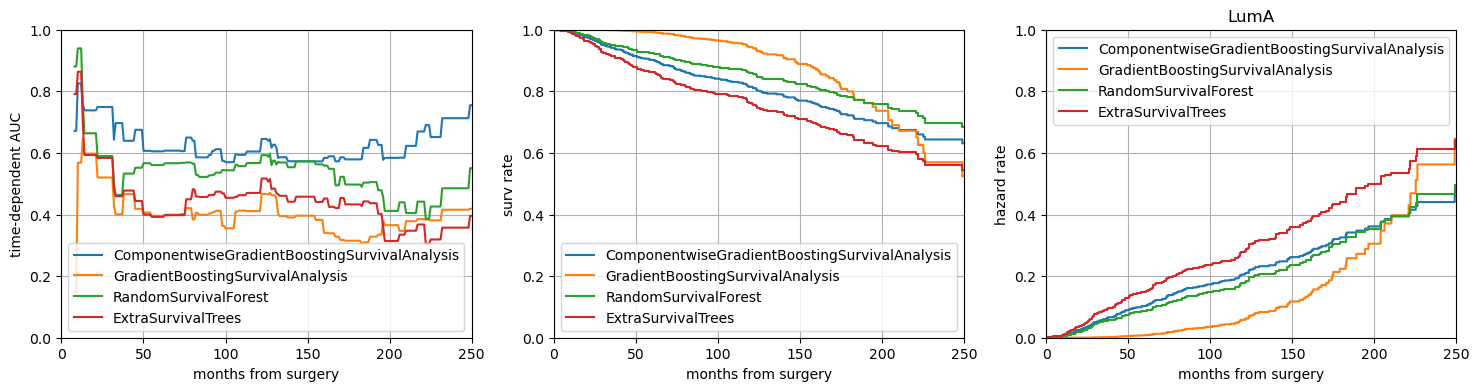

subgroup:  LumB


(414, 244)

(414,)

(46, 244)

(46,)

(414, 244)

(414,)

(46, 244)

(46,)

(414, 244)

(414,)

(46, 244)

(46,)

(414, 244)

(414,)

(46, 244)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.818   
test c-index                                           0.490   
AUC mean                                               0.417   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.914   
test c-index                              0.595                 0.532   
AUC mean                                  0.560                 0.489   

               ExtraSurvivalTrees  
train c-index               0.922  
test c-index                0.508  
AUC mean                    0.446

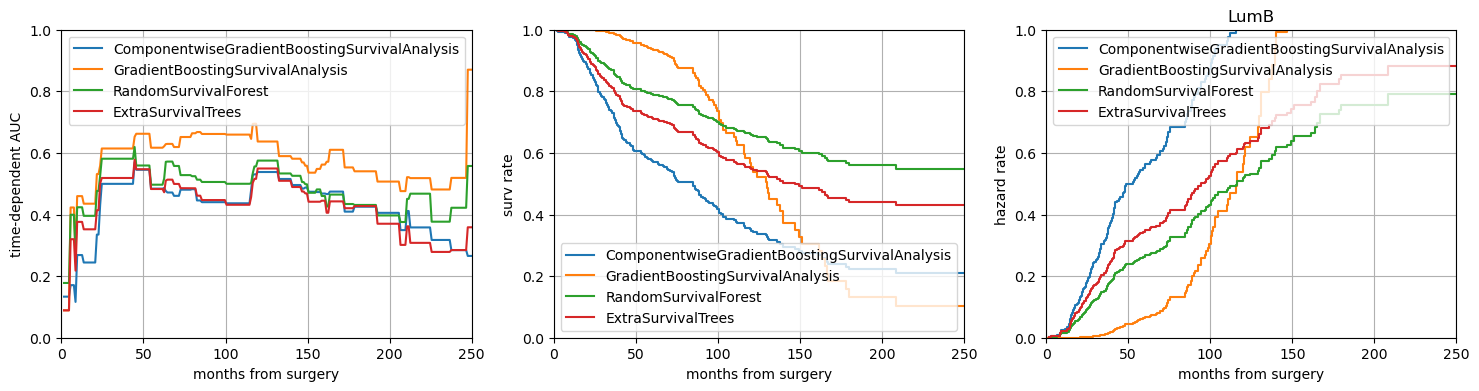

subgroup:  Her2


(196, 119)

(196,)

(22, 119)

(22,)

(196, 119)

(196,)

(22, 119)

(22,)

(196, 119)

(196,)

(22, 119)

(22,)

(196, 119)

(196,)

(22, 119)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.848   
test c-index                                           0.400   
AUC mean                                               0.287   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.915   
test c-index                              0.370                 0.315   
AUC mean                                  0.325                 0.242   

               ExtraSurvivalTrees  
train c-index               0.913  
test c-index                0.382  
AUC mean                    0.324

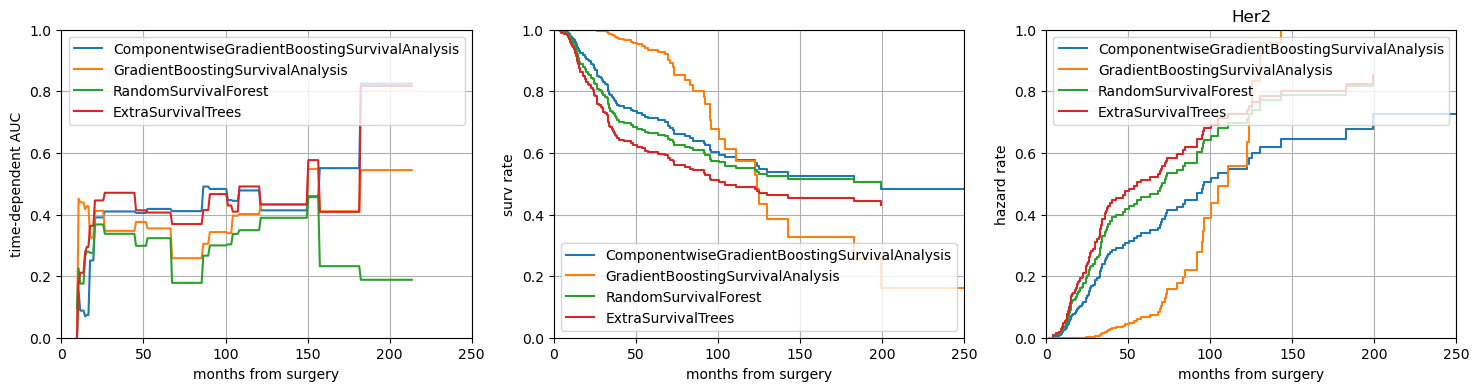

subgroup:  Normal


(126, 78)

(126,)

(14, 78)

(14,)

(126, 78)

(126,)

(14, 78)

(14,)

(126, 78)

(126,)

(14, 78)

(14,)

(126, 78)

(126,)

(14, 78)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.867   
test c-index                                           0.500   
AUC mean                                               0.440   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.913   
test c-index                              0.583                 0.667   
AUC mean                                  0.588                 0.610   

               ExtraSurvivalTrees  
train c-index               0.903  
test c-index                0.567  
AUC mean                    0.512

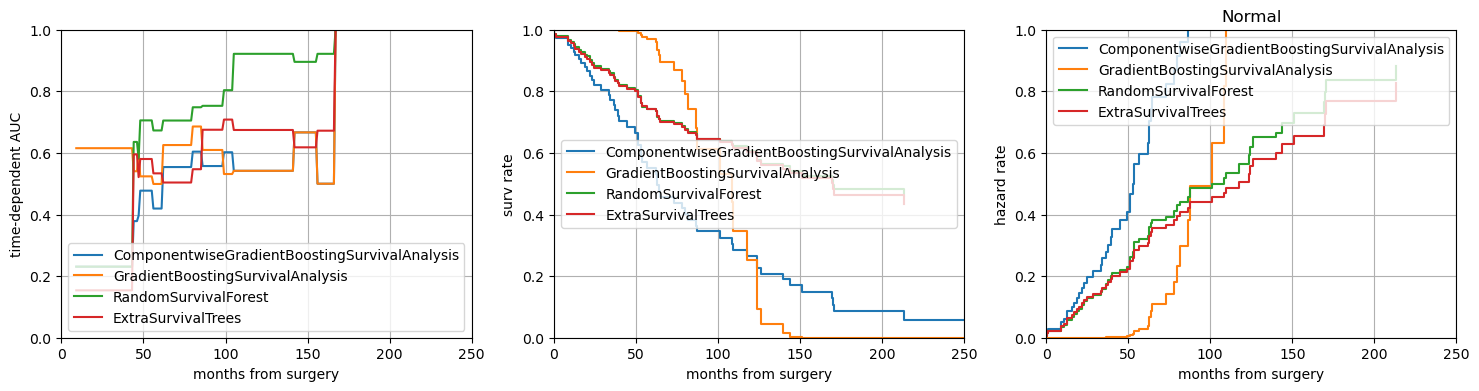

subgroup:  Basal


(179, 111)

(179,)

(20, 111)

(20,)

(179, 111)

(179,)

(20, 111)

(20,)

(179, 111)

(179,)

(20, 111)

(20,)

(179, 111)

(179,)

(20, 111)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.819   
test c-index                                           0.377   
AUC mean                                               0.302   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.930   
test c-index                              0.369                 0.377   
AUC mean                                  0.258                 0.243   

               ExtraSurvivalTrees  
train c-index               0.924  
test c-index                0.377  
AUC mean                    0.242

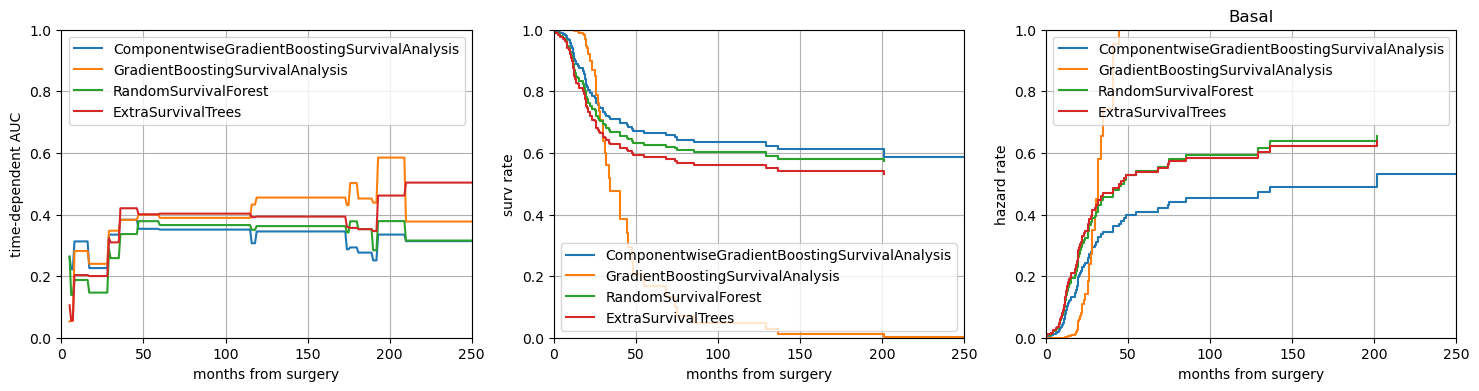

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

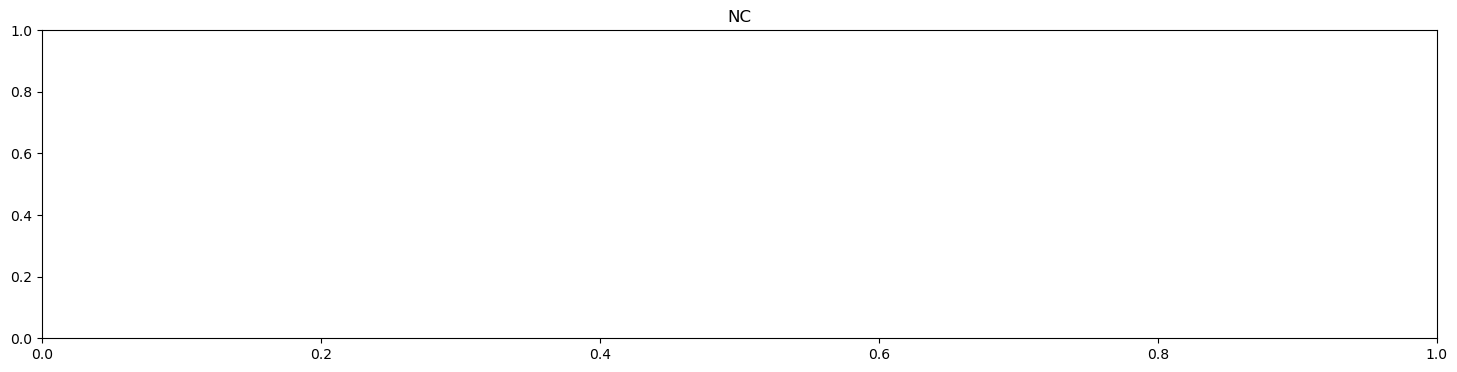

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
81
subgroup:  claudin-low


(177, 108)

(177,)

(20, 108)

(20,)

(177, 108)

(177,)

(20, 108)

(20,)

(177, 108)

(177,)

(20, 108)

(20,)

(177, 108)

(177,)

(20, 108)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.889   
test c-index                                           0.629   
AUC mean                                               0.596   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.933   
test c-index                              0.573                 0.629   
AUC mean                                  0.558                 0.631   

               ExtraSurvivalTrees  
train c-index               0.938  
test c-index                0.596  
AUC mean                    0.582

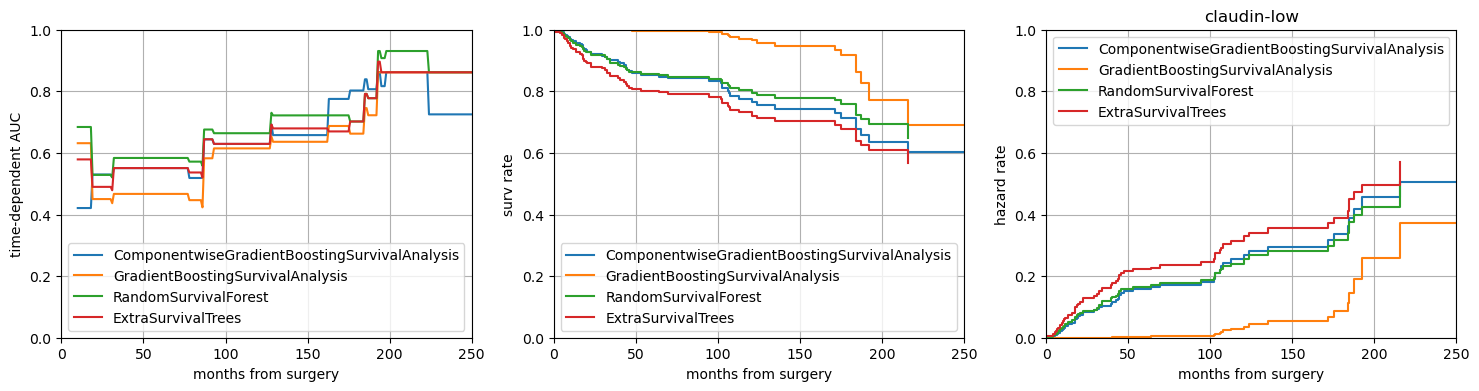

subgroup:  LumA


(605, 352)

(605,)

(68, 352)

(68,)

(605, 352)

(605,)

(68, 352)

(68,)

(605, 352)

(605,)

(68, 352)

(68,)

(605, 352)

(605,)

(68, 352)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.805   
test c-index                                           0.580   
AUC mean                                               0.635   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.951   
test c-index                              0.431                 0.476   
AUC mean                                  0.457                 0.513   

               ExtraSurvivalTrees  
train c-index               0.957  
test c-index                0.551  
AUC mean                    0.605

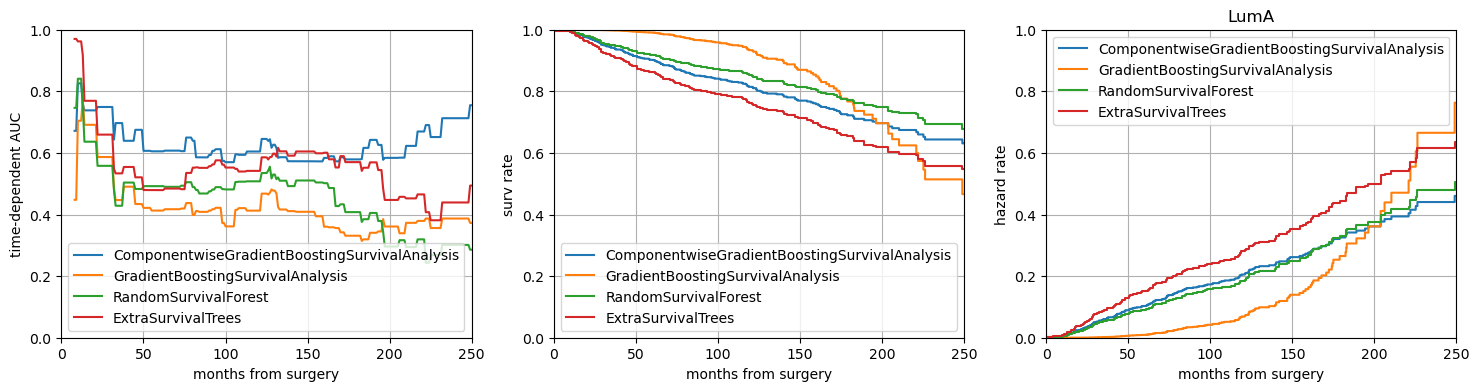

subgroup:  LumB


(414, 251)

(414,)

(46, 251)

(46,)

(414, 251)

(414,)

(46, 251)

(46,)

(414, 251)

(414,)

(46, 251)

(46,)

(414, 251)

(414,)

(46, 251)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.821   
test c-index                                           0.489   
AUC mean                                               0.414   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.915   
test c-index                              0.598                 0.497   
AUC mean                                  0.570                 0.475   

               ExtraSurvivalTrees  
train c-index               0.924  
test c-index                0.486  
AUC mean                    0.475

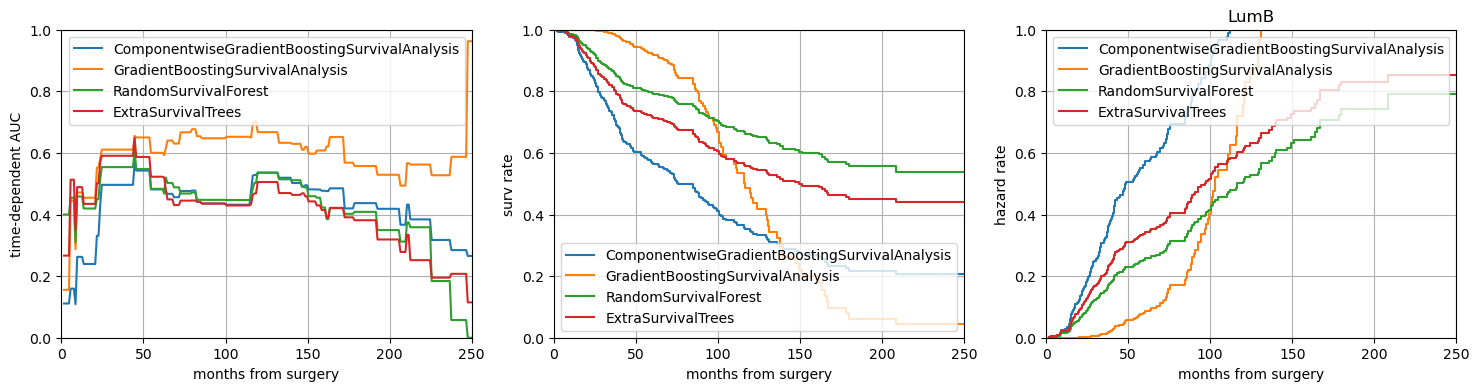

subgroup:  Her2


(196, 122)

(196,)

(22, 122)

(22,)

(196, 122)

(196,)

(22, 122)

(22,)

(196, 122)

(196,)

(22, 122)

(22,)

(196, 122)

(196,)

(22, 122)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.850   
test c-index                                           0.388   
AUC mean                                               0.281   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.999                 0.915   
test c-index                              0.370                 0.309   
AUC mean                                  0.315                 0.230   

               ExtraSurvivalTrees  
train c-index               0.917  
test c-index                0.382  
AUC mean                    0.326

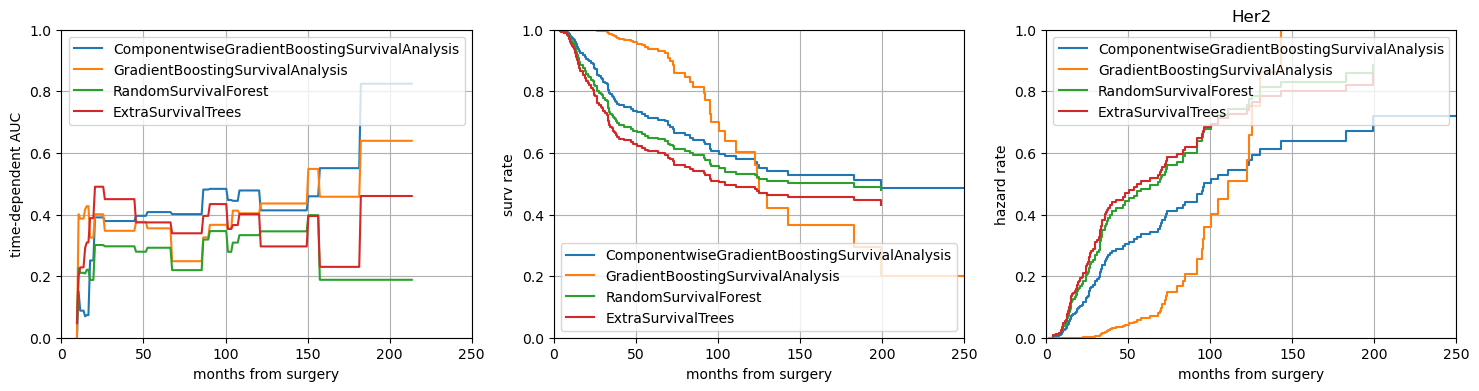

subgroup:  Normal


(126, 80)

(126,)

(14, 80)

(14,)

(126, 80)

(126,)

(14, 80)

(14,)

(126, 80)

(126,)

(14, 80)

(14,)

(126, 80)

(126,)

(14, 80)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.870   
test c-index                                           0.500   
AUC mean                                               0.469   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.916   
test c-index                              0.517                 0.633   
AUC mean                                  0.530                 0.569   

               ExtraSurvivalTrees  
train c-index               0.908  
test c-index                0.500  
AUC mean                    0.467

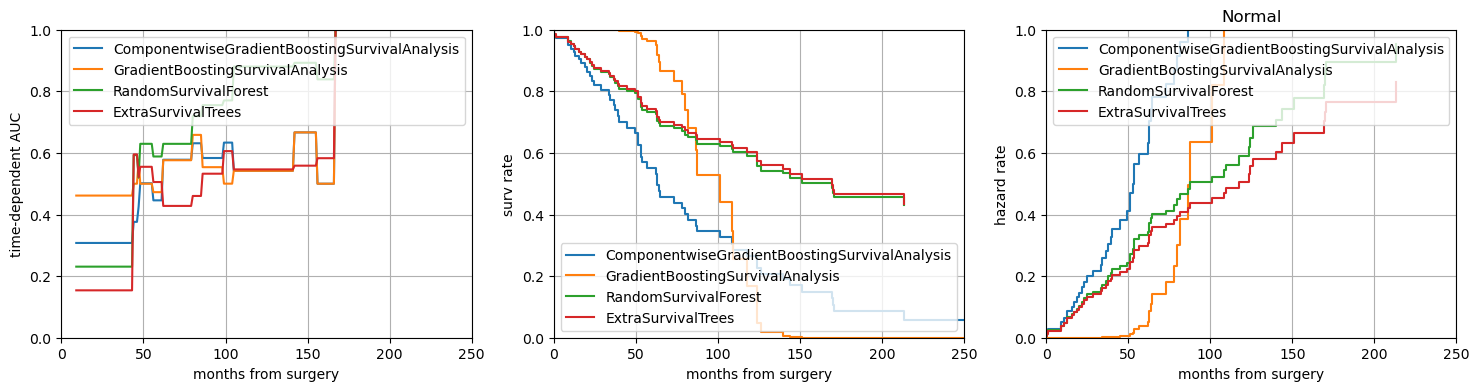

subgroup:  Basal


(179, 114)

(179,)

(20, 114)

(20,)

(179, 114)

(179,)

(20, 114)

(20,)

(179, 114)

(179,)

(20, 114)

(20,)

(179, 114)

(179,)

(20, 114)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.821   
test c-index                                           0.377   
AUC mean                                               0.300   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.929   
test c-index                              0.393                 0.352   
AUC mean                                  0.281                 0.211   

               ExtraSurvivalTrees  
train c-index               0.923  
test c-index                0.295  
AUC mean                    0.164

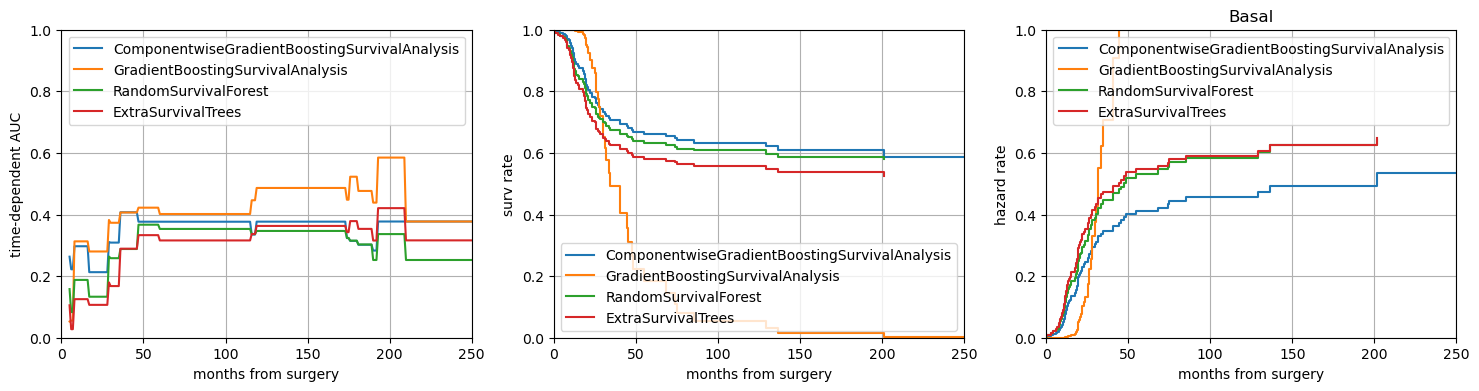

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

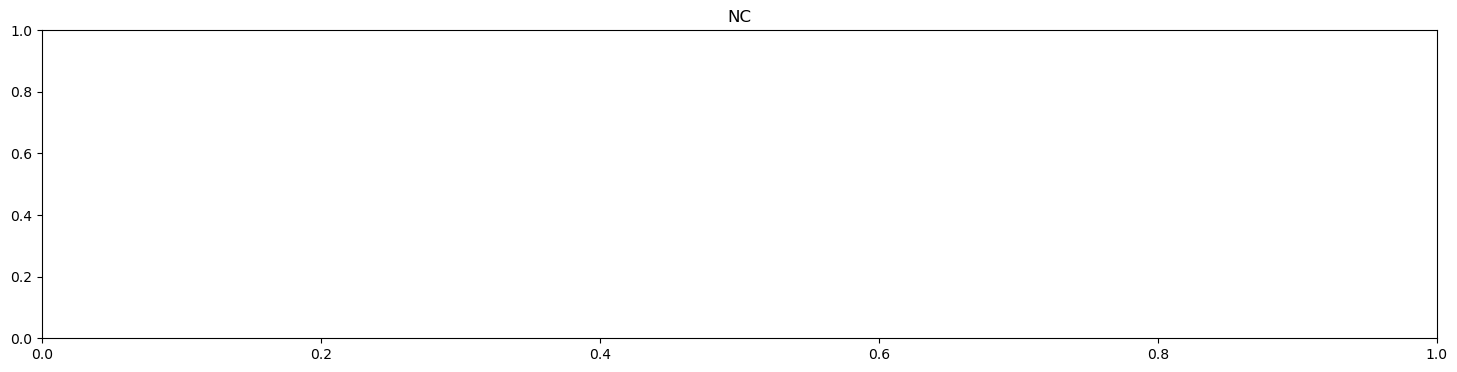

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
82
subgroup:  claudin-low


(177, 111)

(177,)

(20, 111)

(20,)

(177, 111)

(177,)

(20, 111)

(20,)

(177, 111)

(177,)

(20, 111)

(20,)

(177, 111)

(177,)

(20, 111)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.891   
test c-index                                           0.640   
AUC mean                                               0.601   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.607                 0.663   
AUC mean                                  0.600                 0.671   

               ExtraSurvivalTrees  
train c-index               0.931  
test c-index                0.584  
AUC mean                    0.559

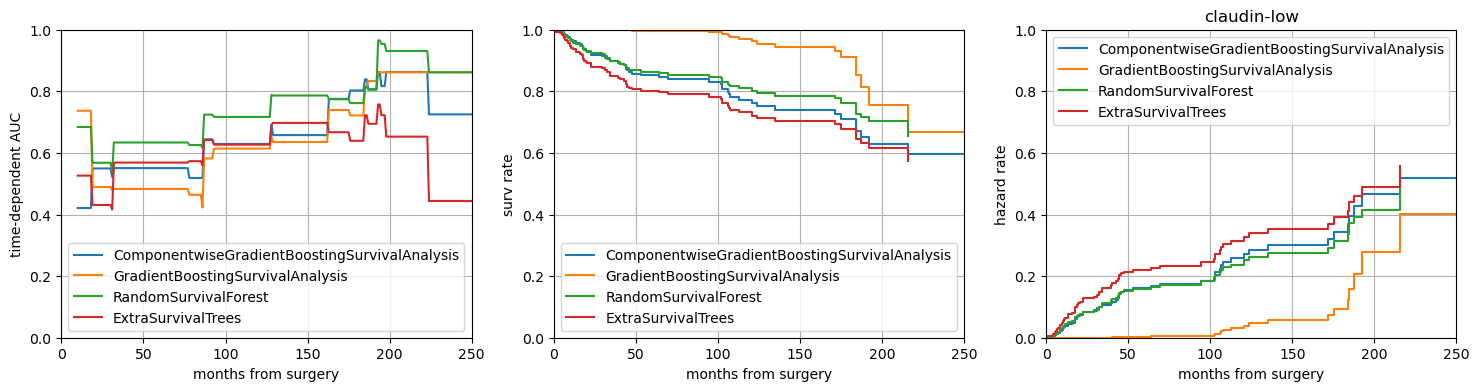

subgroup:  LumA


(605, 363)

(605,)

(68, 363)

(68,)

(605, 363)

(605,)

(68, 363)

(68,)

(605, 363)

(605,)

(68, 363)

(68,)

(605, 363)

(605,)

(68, 363)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.805   
test c-index                                           0.580   
AUC mean                                               0.635   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.952   
test c-index                              0.423                 0.498   
AUC mean                                  0.451                 0.519   

               ExtraSurvivalTrees  
train c-index               0.958  
test c-index                0.500  
AUC mean                    0.546

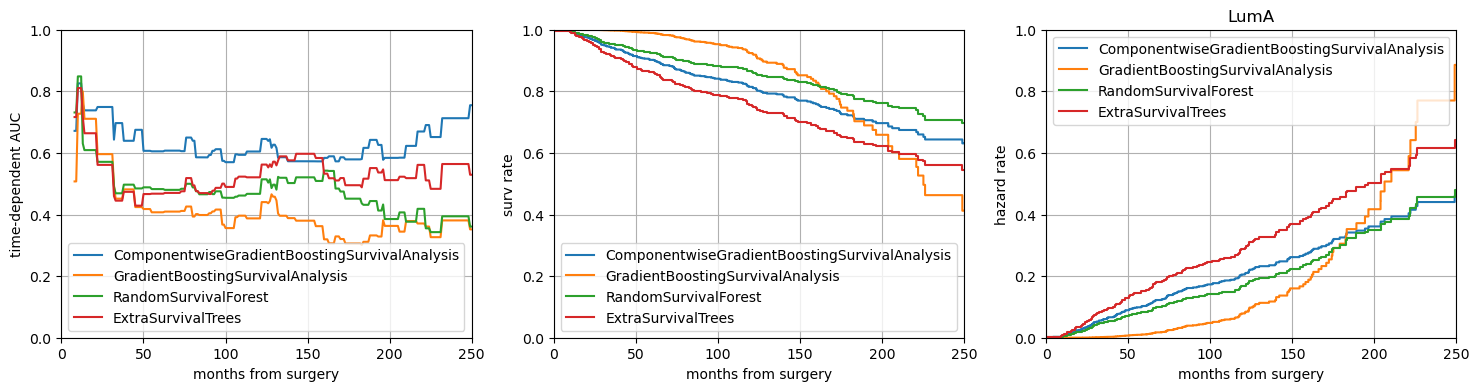

subgroup:  LumB


(414, 258)

(414,)

(46, 258)

(46,)

(414, 258)

(414,)

(46, 258)

(46,)

(414, 258)

(414,)

(46, 258)

(46,)

(414, 258)

(414,)

(46, 258)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.827   
test c-index                                           0.478   
AUC mean                                               0.403   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.918   
test c-index                              0.624                 0.519   
AUC mean                                  0.590                 0.486   

               ExtraSurvivalTrees  
train c-index               0.926  
test c-index                0.430  
AUC mean                    0.366

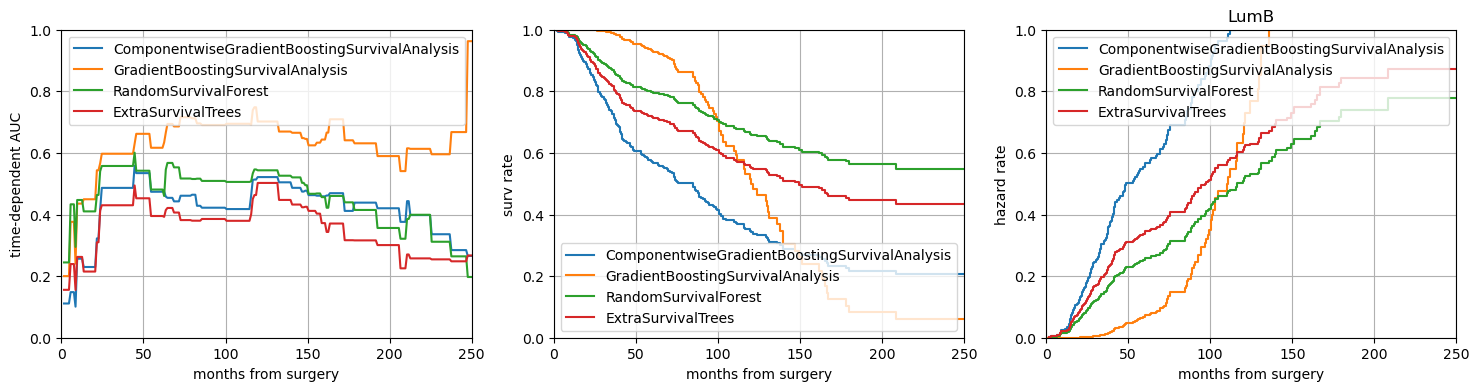

subgroup:  Her2


(196, 126)

(196,)

(22, 126)

(22,)

(196, 126)

(196,)

(22, 126)

(22,)

(196, 126)

(196,)

(22, 126)

(22,)

(196, 126)

(196,)

(22, 126)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.866   
test c-index                                           0.394   
AUC mean                                               0.287   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.914   
test c-index                              0.406                 0.297   
AUC mean                                  0.343                 0.224   

               ExtraSurvivalTrees  
train c-index               0.917  
test c-index                0.327  
AUC mean                    0.255

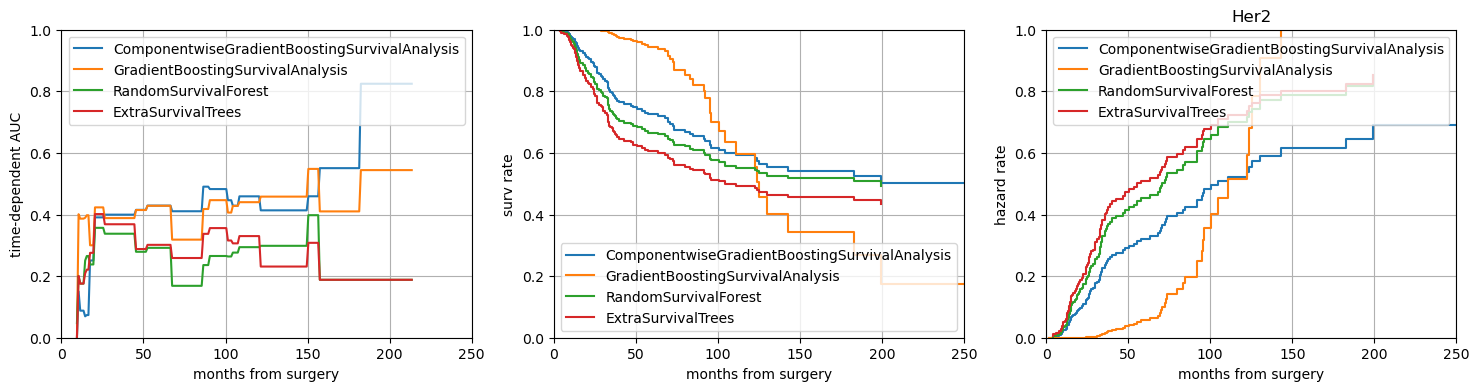

subgroup:  Normal


(126, 82)

(126,)

(14, 82)

(14,)

(126, 82)

(126,)

(14, 82)

(14,)

(126, 82)

(126,)

(14, 82)

(14,)

(126, 82)

(126,)

(14, 82)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.881   
test c-index                                           0.533   
AUC mean                                               0.507   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.923   
test c-index                              0.600                 0.633   
AUC mean                                  0.638                 0.620   

               ExtraSurvivalTrees  
train c-index               0.903  
test c-index                0.567  
AUC mean                    0.511

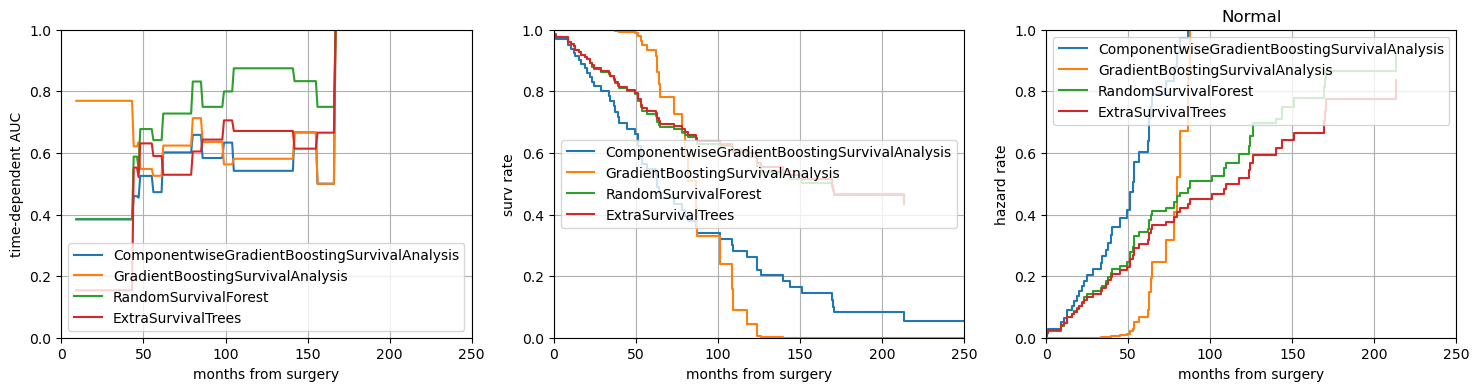

subgroup:  Basal


(179, 117)

(179,)

(20, 117)

(20,)

(179, 117)

(179,)

(20, 117)

(20,)

(179, 117)

(179,)

(20, 117)

(20,)

(179, 117)

(179,)

(20, 117)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.823   
test c-index                                           0.377   
AUC mean                                               0.300   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.934   
test c-index                              0.393                 0.336   
AUC mean                                  0.283                 0.249   

               ExtraSurvivalTrees  
train c-index               0.924  
test c-index                0.295  
AUC mean                    0.188

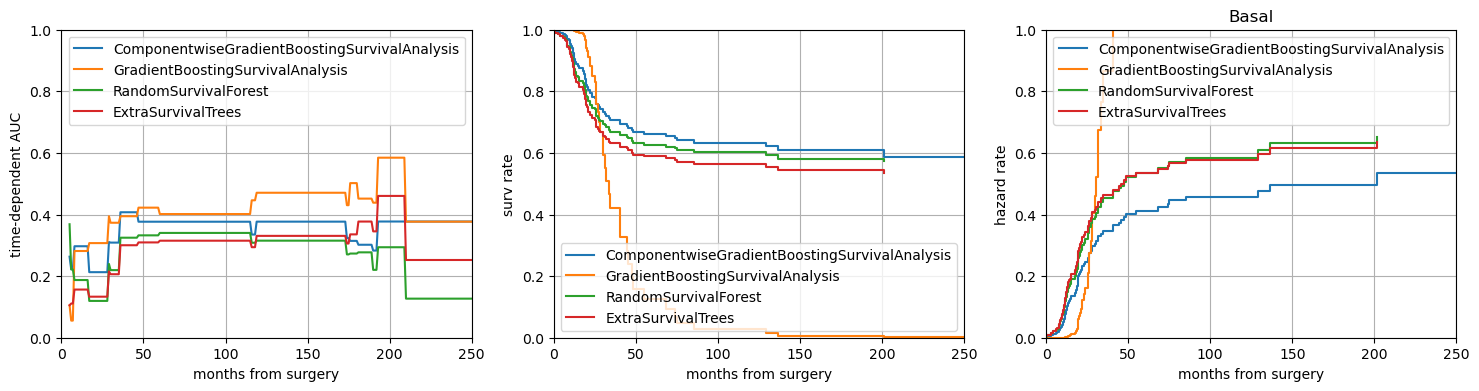

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

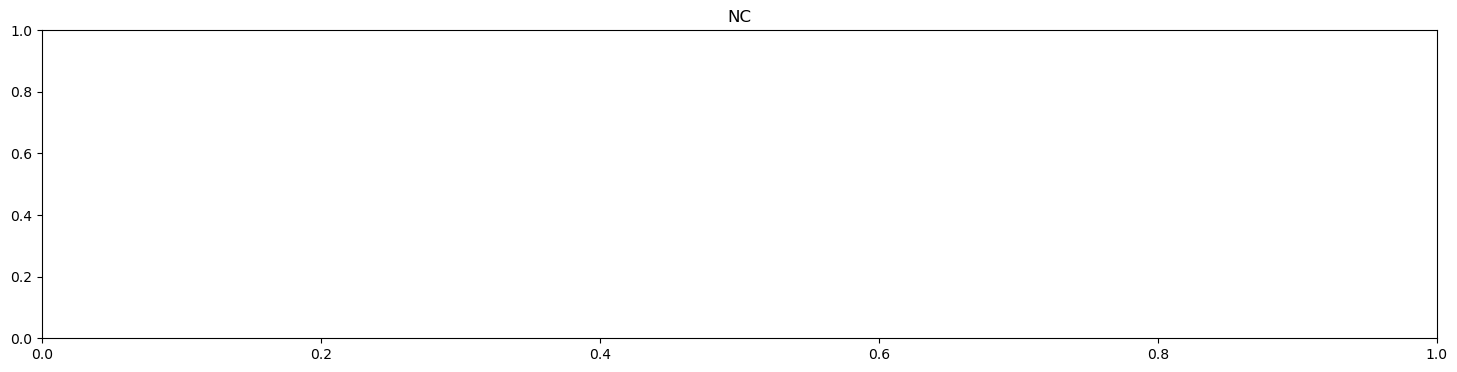

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
83
subgroup:  claudin-low


(177, 114)

(177,)

(20, 114)

(20,)

(177, 114)

(177,)

(20, 114)

(20,)

(177, 114)

(177,)

(20, 114)

(20,)

(177, 114)

(177,)

(20, 114)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.908   
test c-index                                           0.663   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.930   
test c-index                              0.562                 0.652   
AUC mean                                  0.573                 0.656   

               ExtraSurvivalTrees  
train c-index               0.936  
test c-index                0.596  
AUC mean                    0.570

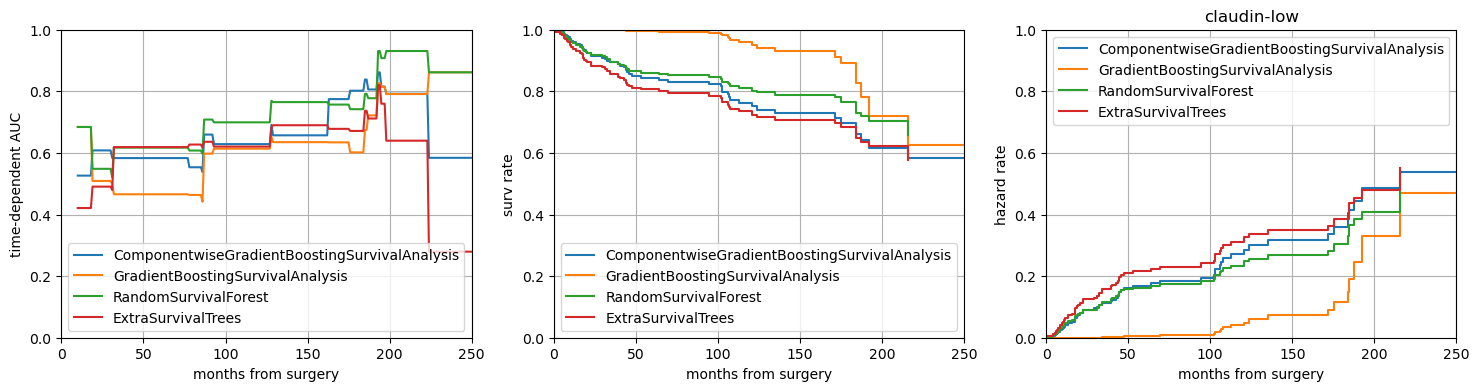

subgroup:  LumA


(605, 374)

(605,)

(68, 374)

(68,)

(605, 374)

(605,)

(68, 374)

(68,)

(605, 374)

(605,)

(68, 374)

(68,)

(605, 374)

(605,)

(68, 374)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.808   
test c-index                                           0.578   
AUC mean                                               0.642   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.952   
test c-index                              0.421                 0.527   
AUC mean                                  0.445                 0.566   

               ExtraSurvivalTrees  
train c-index               0.959  
test c-index                0.570  
AUC mean                    0.611

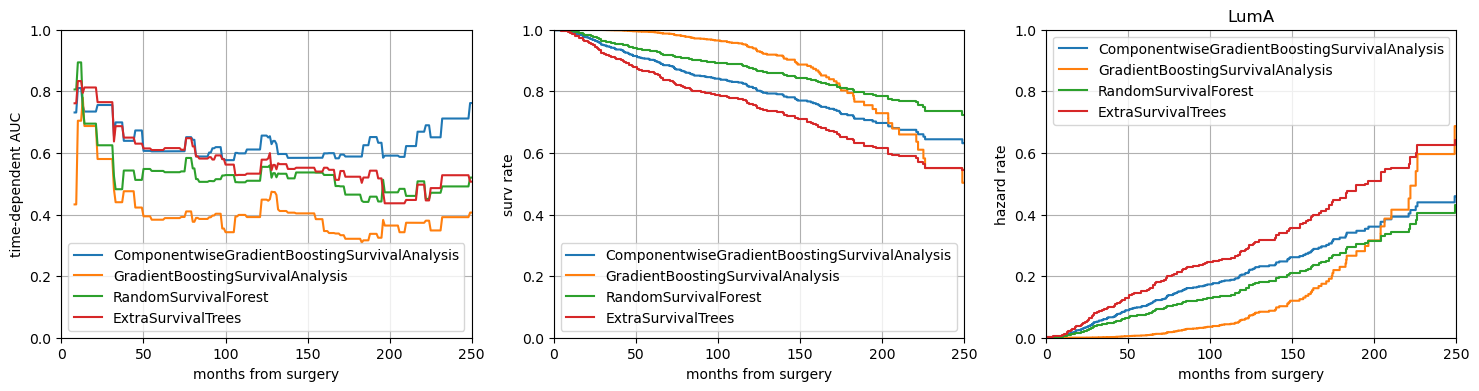

subgroup:  LumB


(414, 265)

(414,)

(46, 265)

(46,)

(414, 265)

(414,)

(46, 265)

(46,)

(414, 265)

(414,)

(46, 265)

(46,)

(414, 265)

(414,)

(46, 265)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.830   
test c-index                                           0.488   
AUC mean                                               0.417   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.921   
test c-index                              0.615                 0.546   
AUC mean                                  0.587                 0.486   

               ExtraSurvivalTrees  
train c-index               0.927  
test c-index                0.477  
AUC mean                    0.422

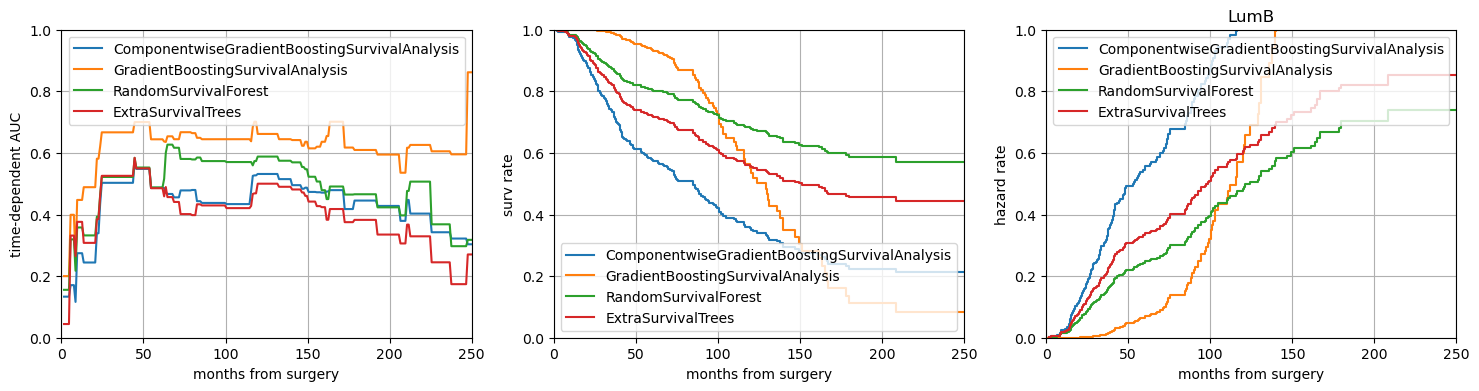

subgroup:  Her2


(196, 129)

(196,)

(22, 129)

(22,)

(196, 129)

(196,)

(22, 129)

(22,)

(196, 129)

(196,)

(22, 129)

(22,)

(196, 129)

(196,)

(22, 129)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.866   
test c-index                                           0.388   
AUC mean                                               0.283   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.926   
test c-index                              0.442                 0.327   
AUC mean                                  0.382                 0.267   

               ExtraSurvivalTrees  
train c-index               0.915  
test c-index                0.321  
AUC mean                    0.252

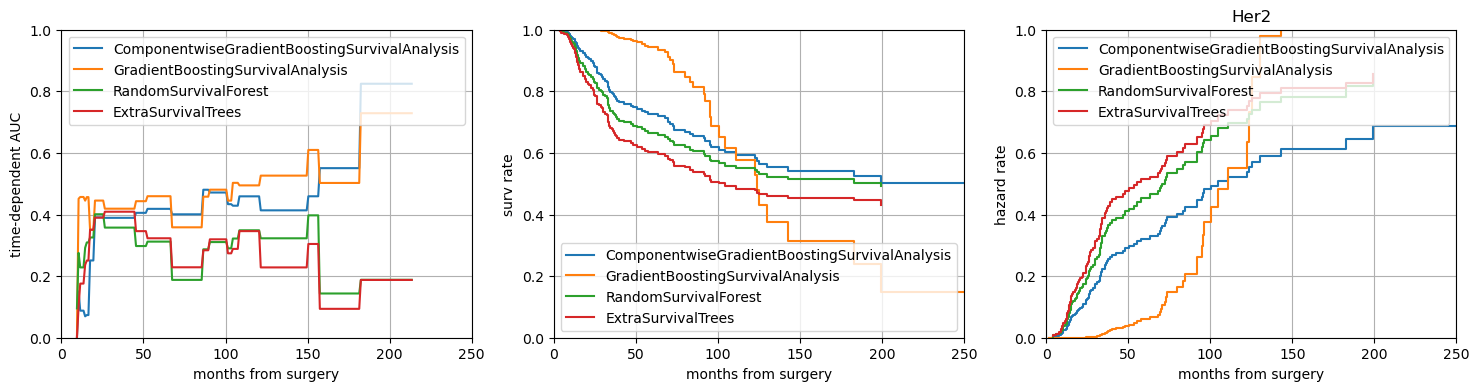

subgroup:  Normal


(126, 84)

(126,)

(14, 84)

(14,)

(126, 84)

(126,)

(14, 84)

(14,)

(126, 84)

(126,)

(14, 84)

(14,)

(126, 84)

(126,)

(14, 84)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.881   
test c-index                                           0.533   
AUC mean                                               0.507   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.921   
test c-index                              0.600                 0.683   
AUC mean                                  0.638                 0.655   

               ExtraSurvivalTrees  
train c-index               0.918  
test c-index                0.550  
AUC mean                    0.560

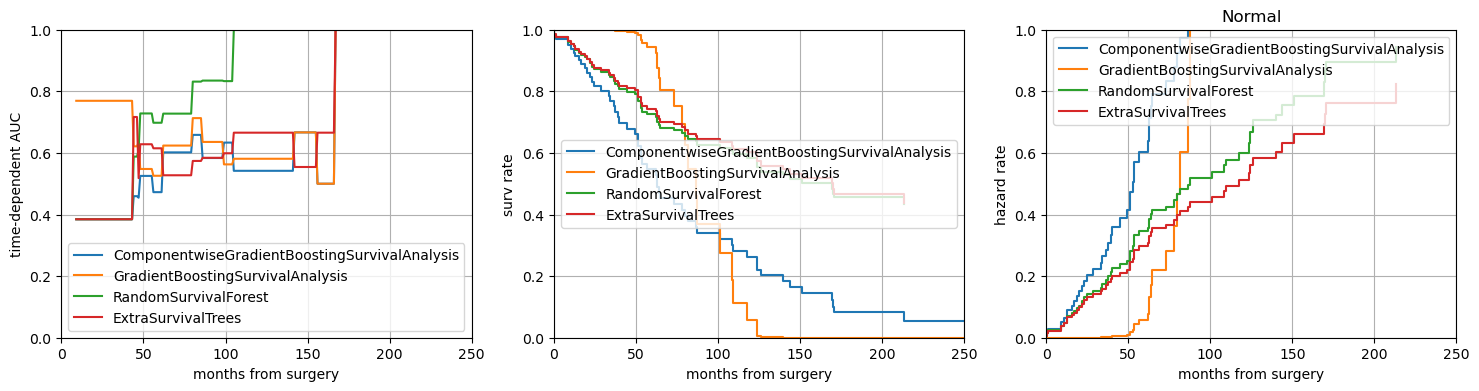

subgroup:  Basal


(179, 120)

(179,)

(20, 120)

(20,)

(179, 120)

(179,)

(20, 120)

(20,)

(179, 120)

(179,)

(20, 120)

(20,)

(179, 120)

(179,)

(20, 120)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.843   
test c-index                                           0.328   
AUC mean                                               0.265   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.931   
test c-index                              0.361                 0.311   
AUC mean                                  0.270                 0.194   

               ExtraSurvivalTrees  
train c-index               0.917  
test c-index                0.443  
AUC mean                    0.335

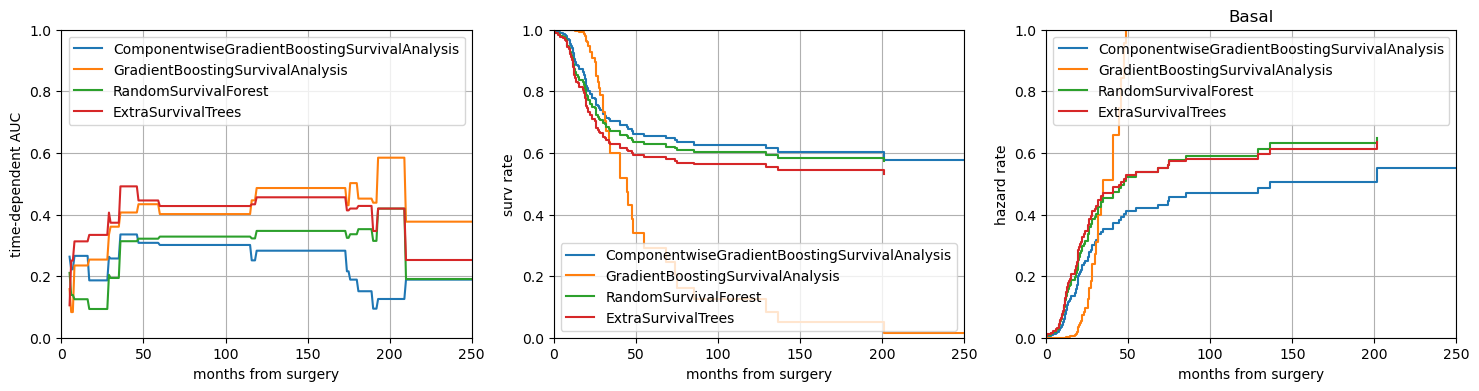

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

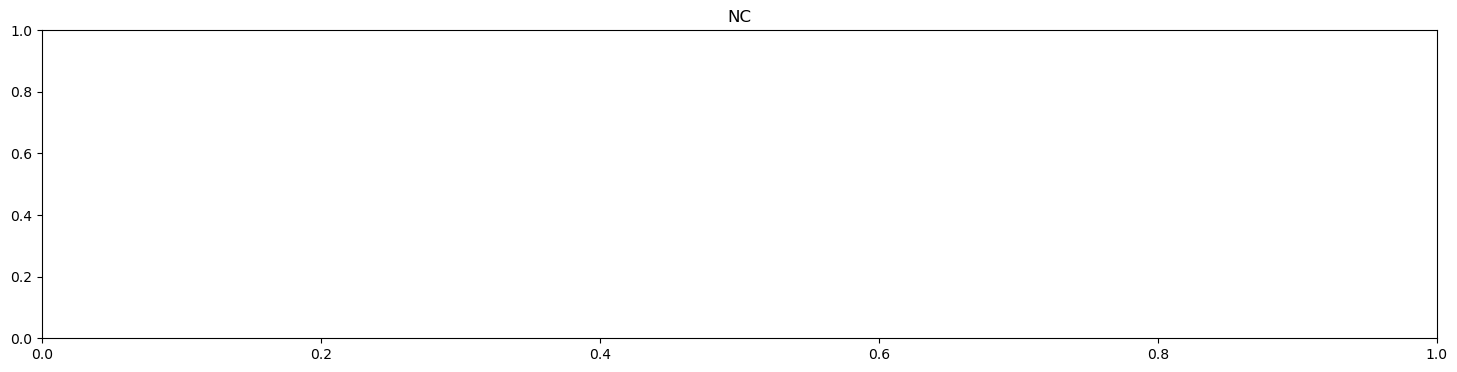

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
84
subgroup:  claudin-low


(177, 117)

(177,)

(20, 117)

(20,)

(177, 117)

(177,)

(20, 117)

(20,)

(177, 117)

(177,)

(20, 117)

(20,)

(177, 117)

(177,)

(20, 117)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.908   
test c-index                                           0.663   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.584                 0.674   
AUC mean                                  0.591                 0.694   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.652  
AUC mean                    0.628

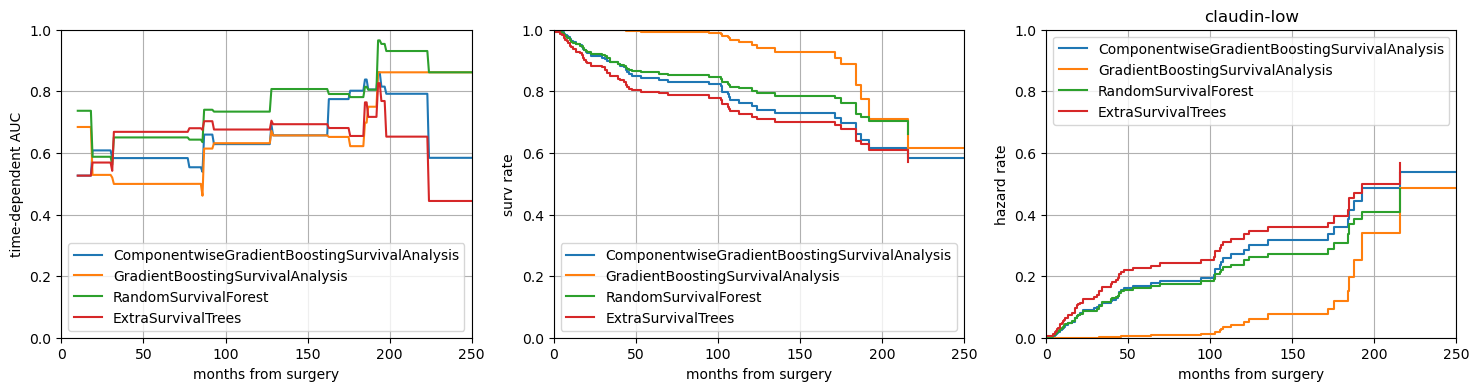

subgroup:  LumA


(605, 386)

(605,)

(68, 386)

(68,)

(605, 386)

(605,)

(68, 386)

(68,)

(605, 386)

(605,)

(68, 386)

(68,)

(605, 386)

(605,)

(68, 386)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.809   
test c-index                                           0.578   
AUC mean                                               0.643   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.952   
test c-index                              0.413                 0.491   
AUC mean                                  0.424                 0.515   

               ExtraSurvivalTrees  
train c-index               0.960  
test c-index                0.485  
AUC mean                    0.554

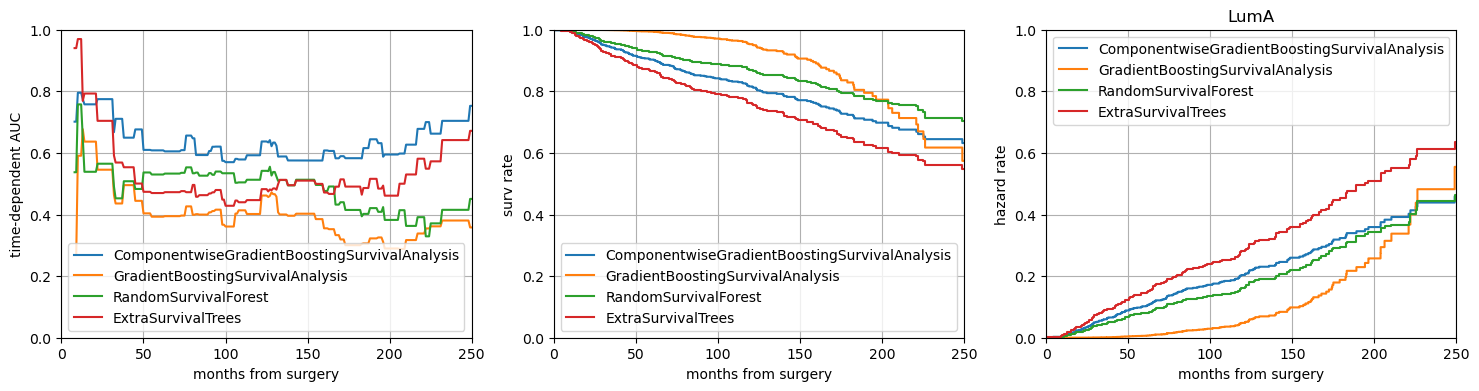

subgroup:  LumB


(414, 273)

(414,)

(46, 273)

(46,)

(414, 273)

(414,)

(46, 273)

(46,)

(414, 273)

(414,)

(46, 273)

(46,)

(414, 273)

(414,)

(46, 273)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.835   
test c-index                                           0.481   
AUC mean                                               0.413   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.923   
test c-index                              0.575                 0.557   
AUC mean                                  0.519                 0.519   

               ExtraSurvivalTrees  
train c-index               0.931  
test c-index                0.456  
AUC mean                    0.401

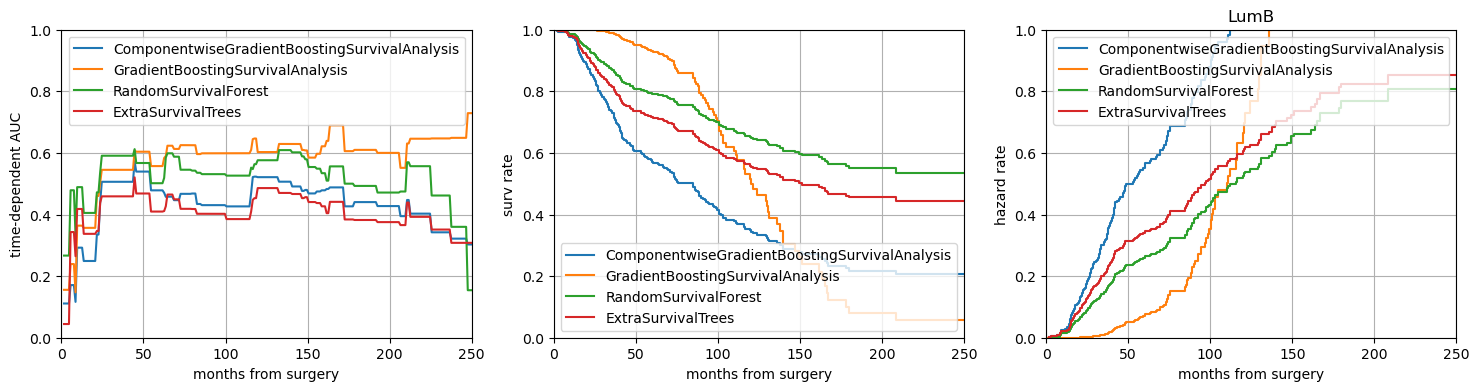

subgroup:  Her2


(196, 132)

(196,)

(22, 132)

(22,)

(196, 132)

(196,)

(22, 132)

(22,)

(196, 132)

(196,)

(22, 132)

(22,)

(196, 132)

(196,)

(22, 132)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.869   
test c-index                                           0.364   
AUC mean                                               0.263   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.923   
test c-index                              0.406                 0.333   
AUC mean                                  0.358                 0.265   

               ExtraSurvivalTrees  
train c-index               0.920  
test c-index                0.382  
AUC mean                    0.332

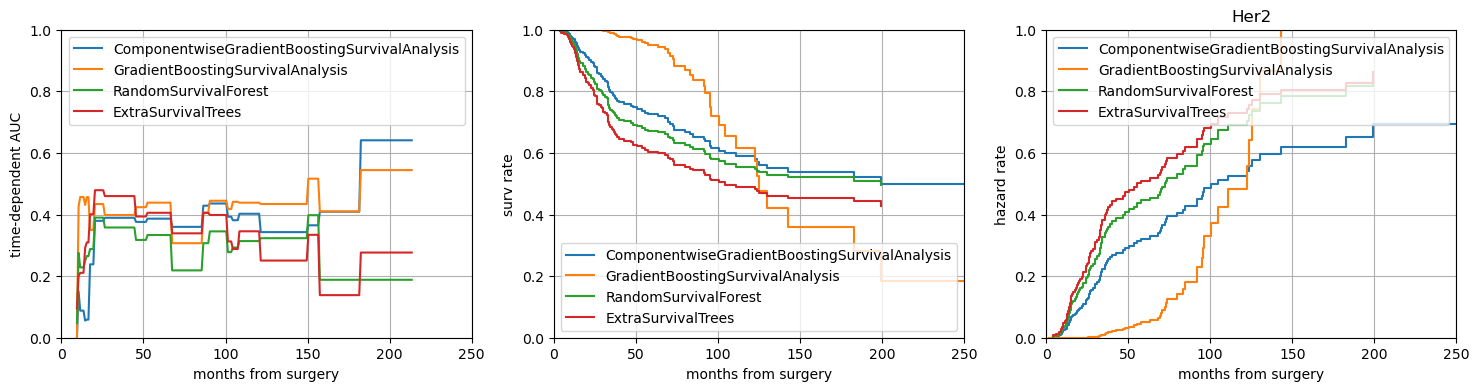

subgroup:  Normal


(126, 86)

(126,)

(14, 86)

(14,)

(126, 86)

(126,)

(14, 86)

(14,)

(126, 86)

(126,)

(14, 86)

(14,)

(126, 86)

(126,)

(14, 86)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.880   
test c-index                                           0.533   
AUC mean                                               0.512   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.922   
test c-index                              0.600                 0.550   
AUC mean                                  0.624                 0.527   

               ExtraSurvivalTrees  
train c-index               0.906  
test c-index                0.567  
AUC mean                    0.493

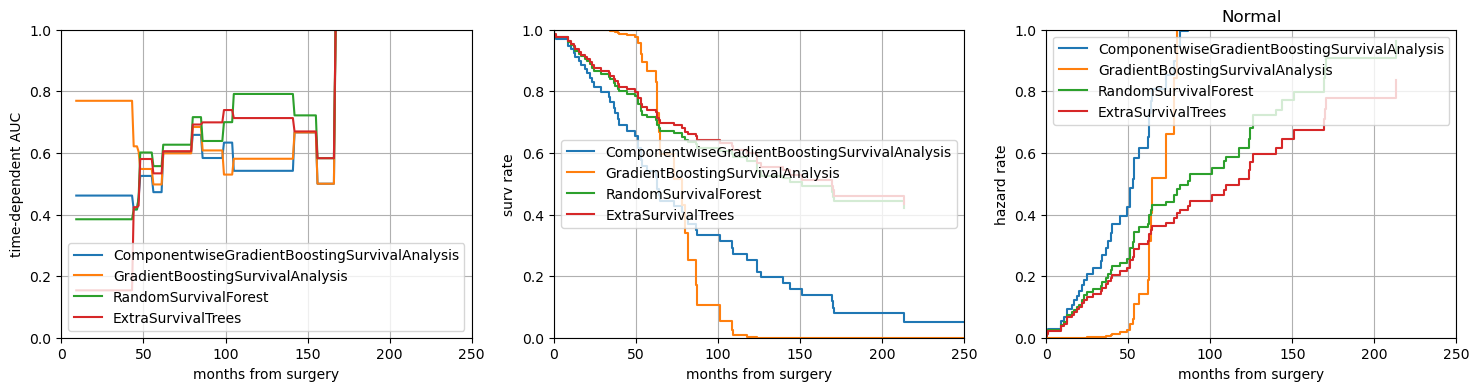

subgroup:  Basal


(179, 123)

(179,)

(20, 123)

(20,)

(179, 123)

(179,)

(20, 123)

(20,)

(179, 123)

(179,)

(20, 123)

(20,)

(179, 123)

(179,)

(20, 123)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.848   
test c-index                                           0.336   
AUC mean                                               0.271   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.933   
test c-index                              0.402                 0.287   
AUC mean                                  0.304                 0.173   

               ExtraSurvivalTrees  
train c-index               0.930  
test c-index                0.377  
AUC mean                    0.273

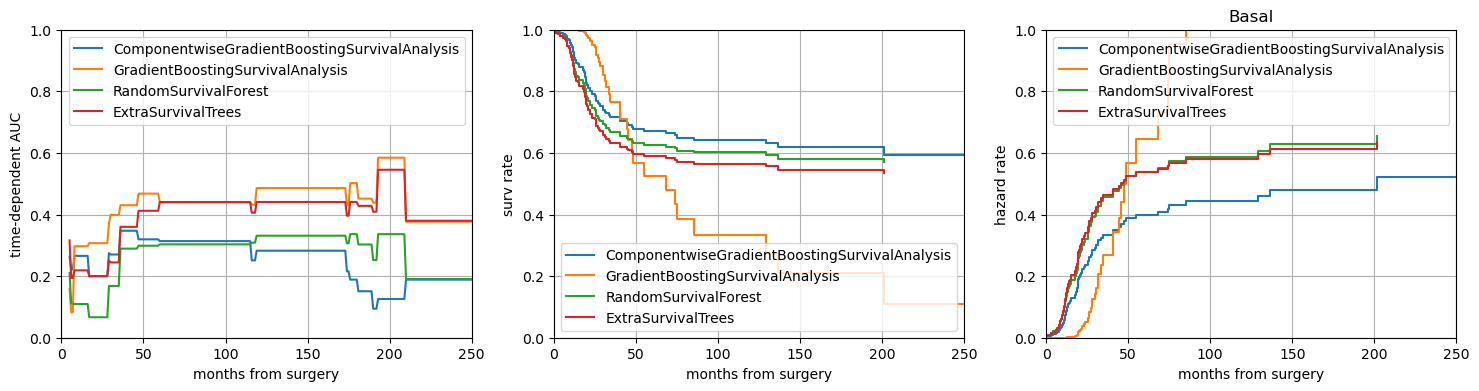

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

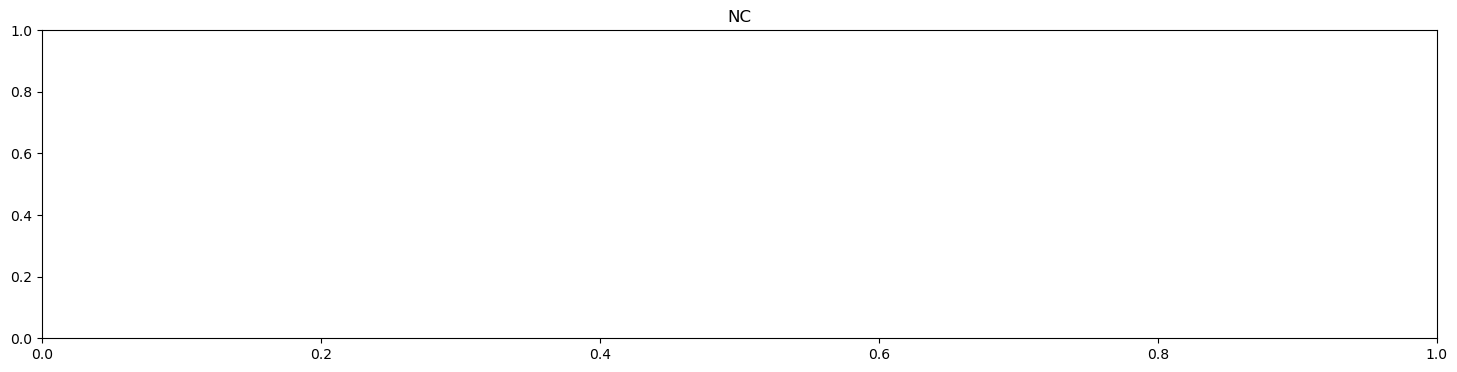

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
85
subgroup:  claudin-low


(177, 120)

(177,)

(20, 120)

(20,)

(177, 120)

(177,)

(20, 120)

(20,)

(177, 120)

(177,)

(20, 120)

(20,)

(177, 120)

(177,)

(20, 120)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.908   
test c-index                                           0.663   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.584                 0.719   
AUC mean                                  0.578                 0.735   

               ExtraSurvivalTrees  
train c-index               0.938  
test c-index                0.629  
AUC mean                    0.614

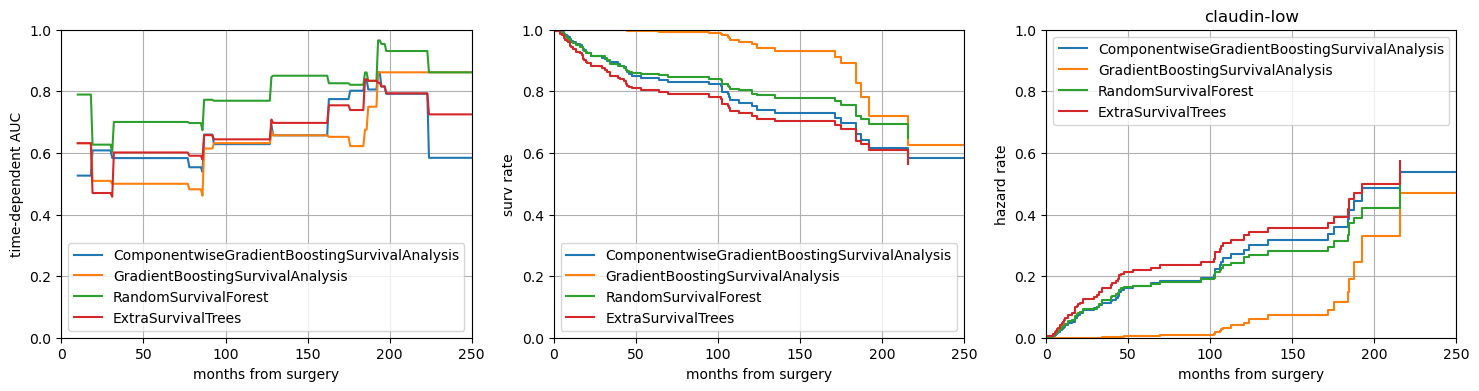

subgroup:  LumA


(605, 397)

(605,)

(68, 397)

(68,)

(605, 397)

(605,)

(68, 397)

(68,)

(605, 397)

(605,)

(68, 397)

(68,)

(605, 397)

(605,)

(68, 397)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.808   
test c-index                                           0.577   
AUC mean                                               0.642   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.997                 0.953   
test c-index                              0.413                 0.509   
AUC mean                                  0.421                 0.528   

               ExtraSurvivalTrees  
train c-index               0.960  
test c-index                0.498  
AUC mean                    0.512

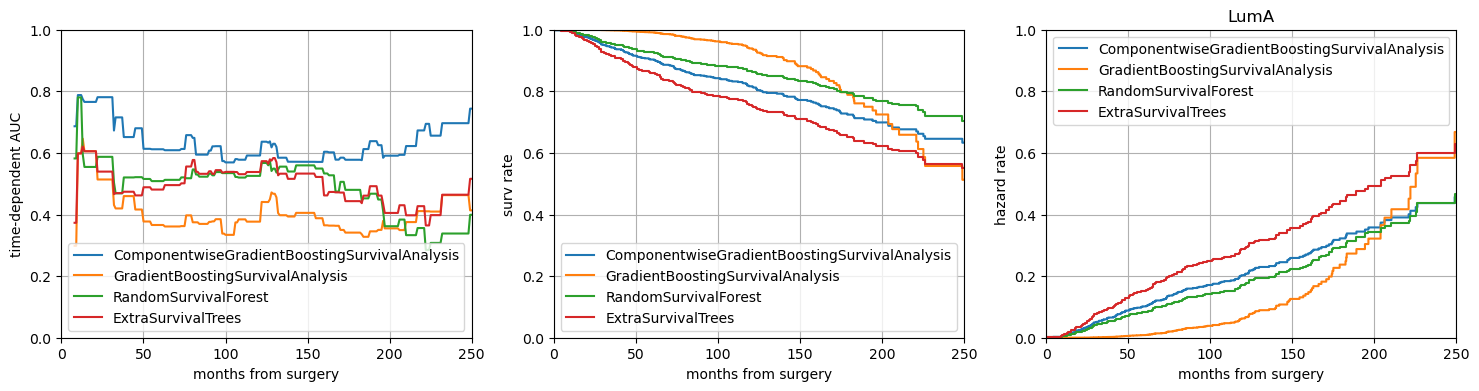

subgroup:  LumB


(414, 280)

(414,)

(46, 280)

(46,)

(414, 280)

(414,)

(46, 280)

(46,)

(414, 280)

(414,)

(46, 280)

(46,)

(414, 280)

(414,)

(46, 280)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.838   
test c-index                                           0.483   
AUC mean                                               0.418   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.926   
test c-index                              0.565                 0.501   
AUC mean                                  0.514                 0.470   

               ExtraSurvivalTrees  
train c-index               0.930  
test c-index                0.452  
AUC mean                    0.408

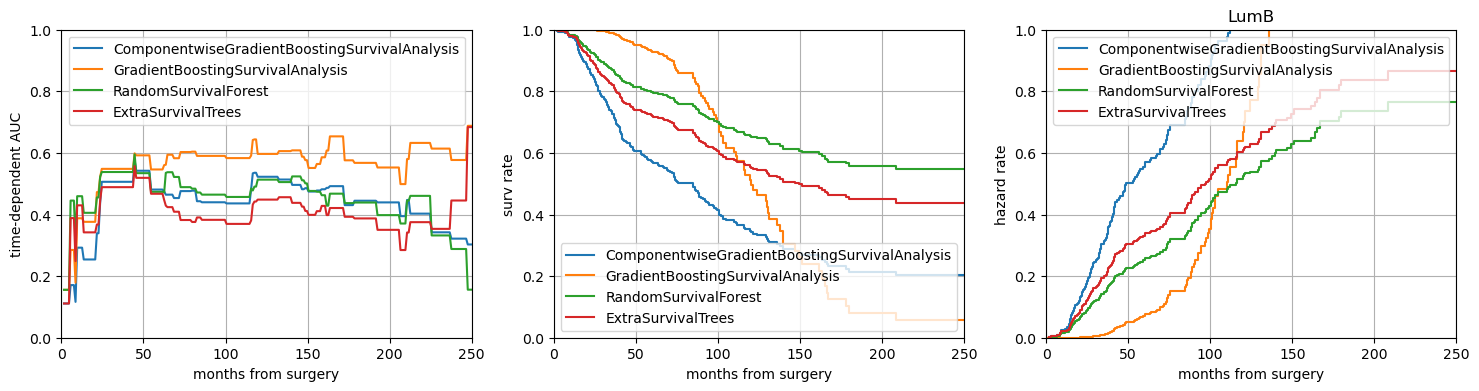

subgroup:  Her2


(196, 136)

(196,)

(22, 136)

(22,)

(196, 136)

(196,)

(22, 136)

(22,)

(196, 136)

(196,)

(22, 136)

(22,)

(196, 136)

(196,)

(22, 136)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.874   
test c-index                                           0.364   
AUC mean                                               0.264   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.921   
test c-index                              0.424                 0.327   
AUC mean                                  0.362                 0.265   

               ExtraSurvivalTrees  
train c-index               0.920  
test c-index                0.352  
AUC mean                    0.291

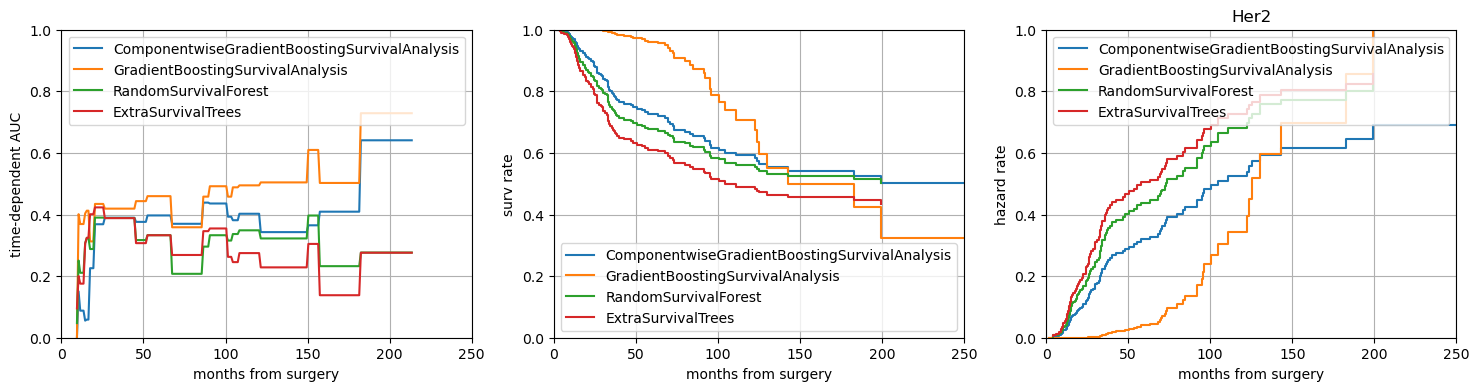

subgroup:  Normal


(126, 88)

(126,)

(14, 88)

(14,)

(126, 88)

(126,)

(14, 88)

(14,)

(126, 88)

(126,)

(14, 88)

(14,)

(126, 88)

(126,)

(14, 88)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.891   
test c-index                                           0.567   
AUC mean                                               0.537   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.920   
test c-index                              0.600                 0.700   
AUC mean                                  0.624                 0.692   

               ExtraSurvivalTrees  
train c-index               0.911  
test c-index                0.467  
AUC mean                    0.473

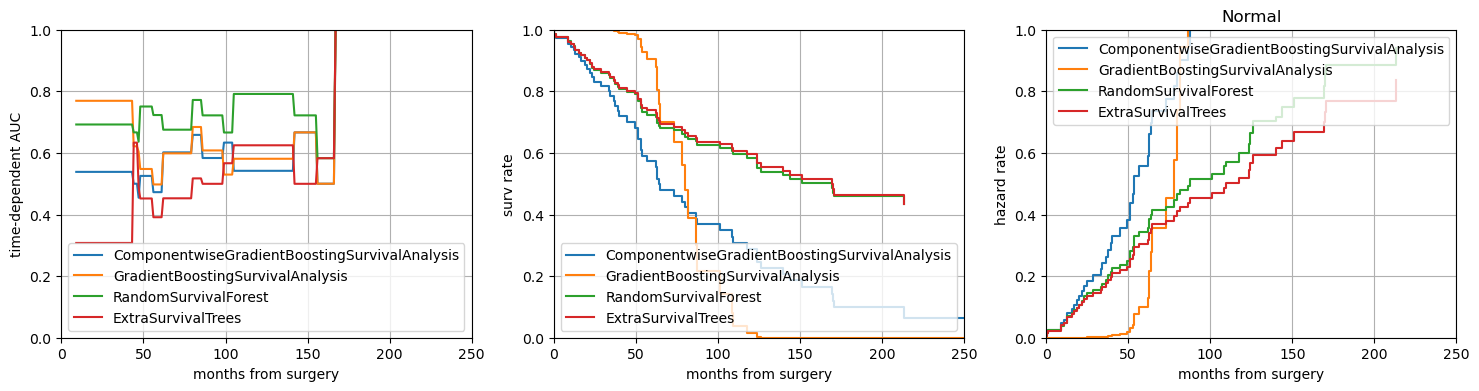

subgroup:  Basal


(179, 126)

(179,)

(20, 126)

(20,)

(179, 126)

(179,)

(20, 126)

(20,)

(179, 126)

(179,)

(20, 126)

(20,)

(179, 126)

(179,)

(20, 126)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.848   
test c-index                                           0.336   
AUC mean                                               0.271   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.938   
test c-index                              0.369                 0.303   
AUC mean                                  0.282                 0.202   

               ExtraSurvivalTrees  
train c-index               0.928  
test c-index                0.369  
AUC mean                    0.292

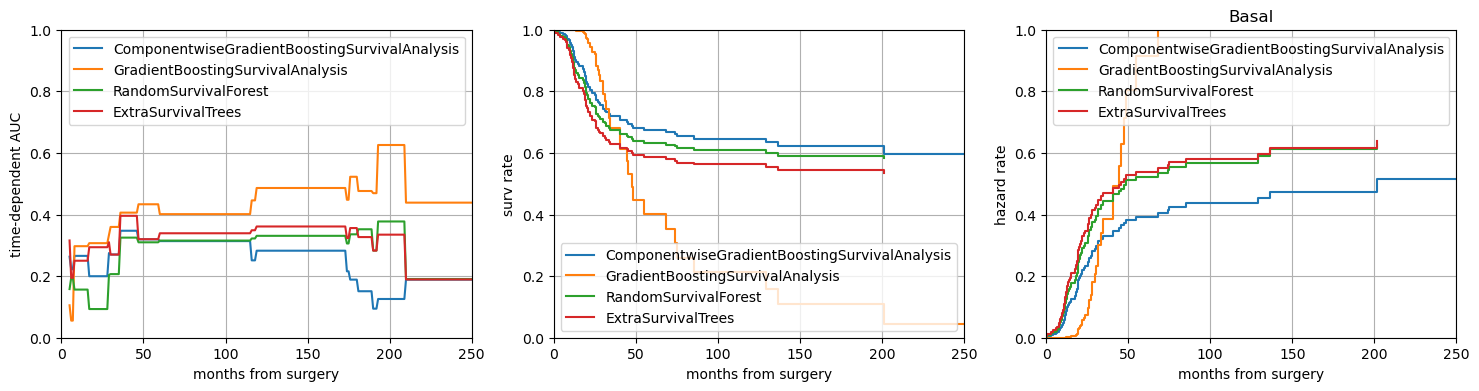

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

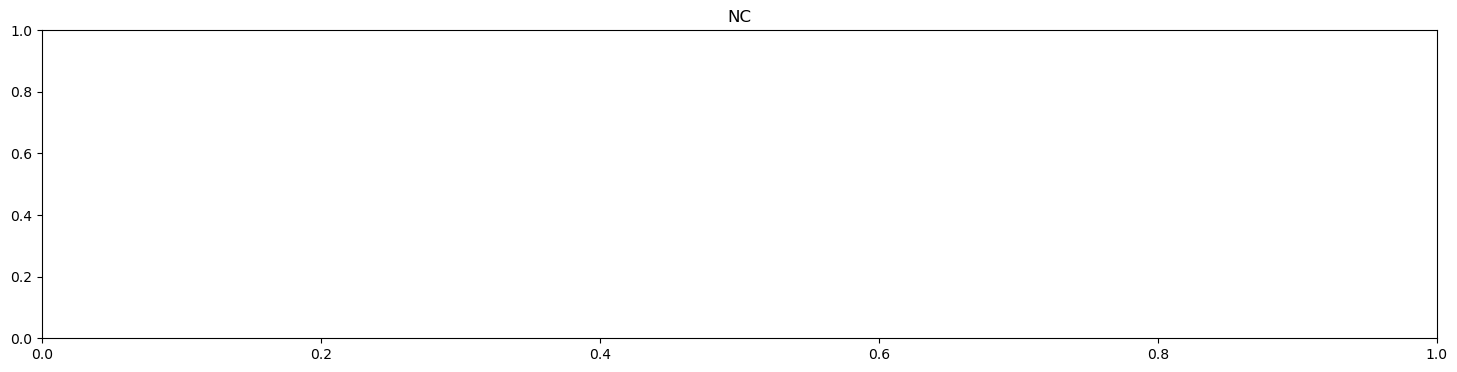

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
86
subgroup:  claudin-low


(177, 124)

(177,)

(20, 124)

(20,)

(177, 124)

(177,)

(20, 124)

(20,)

(177, 124)

(177,)

(20, 124)

(20,)

(177, 124)

(177,)

(20, 124)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.908   
test c-index                                           0.674   
AUC mean                                               0.651   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.934   
test c-index                              0.596                 0.652   
AUC mean                                  0.591                 0.648   

               ExtraSurvivalTrees  
train c-index               0.938  
test c-index                0.618  
AUC mean                    0.605

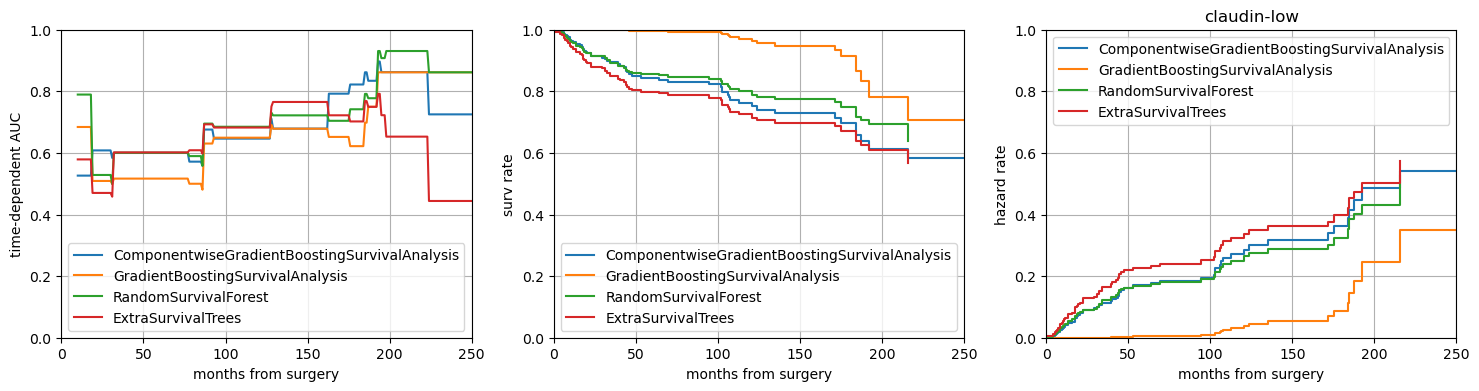

subgroup:  LumA


(605, 409)

(605,)

(68, 409)

(68,)

(605, 409)

(605,)

(68, 409)

(68,)

(605, 409)

(605,)

(68, 409)

(68,)

(605, 409)

(605,)

(68, 409)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.808   
test c-index                                           0.577   
AUC mean                                               0.642   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.951   
test c-index                              0.423                 0.457   
AUC mean                                  0.431                 0.483   

               ExtraSurvivalTrees  
train c-index               0.960  
test c-index                0.443  
AUC mean                    0.486

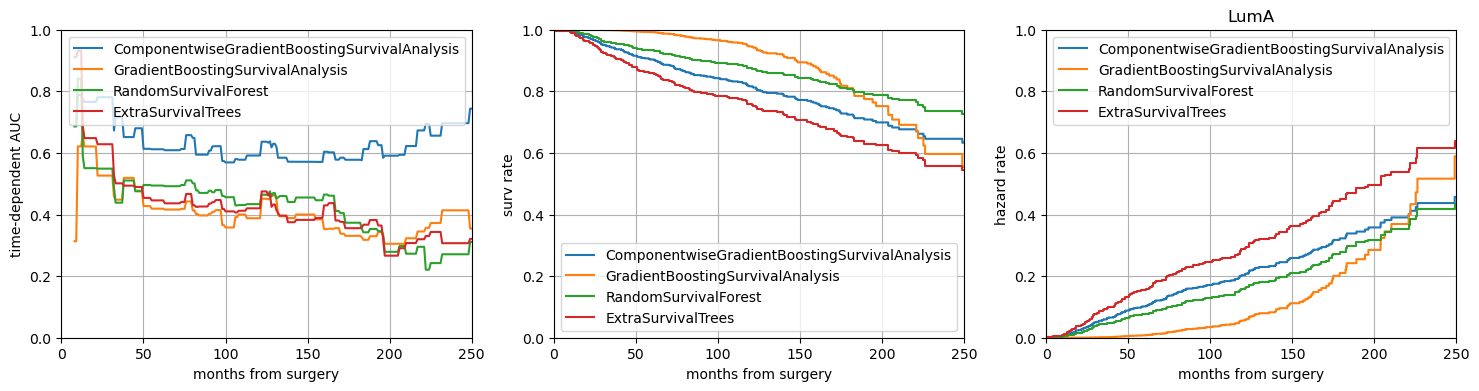

subgroup:  LumB


(414, 288)

(414,)

(46, 288)

(46,)

(414, 288)

(414,)

(46, 288)

(46,)

(414, 288)

(414,)

(46, 288)

(46,)

(414, 288)

(414,)

(46, 288)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.840   
test c-index                                           0.489   
AUC mean                                               0.423   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.928   
test c-index                              0.550                 0.525   
AUC mean                                  0.493                 0.482   

               ExtraSurvivalTrees  
train c-index               0.932  
test c-index                0.474  
AUC mean                    0.444

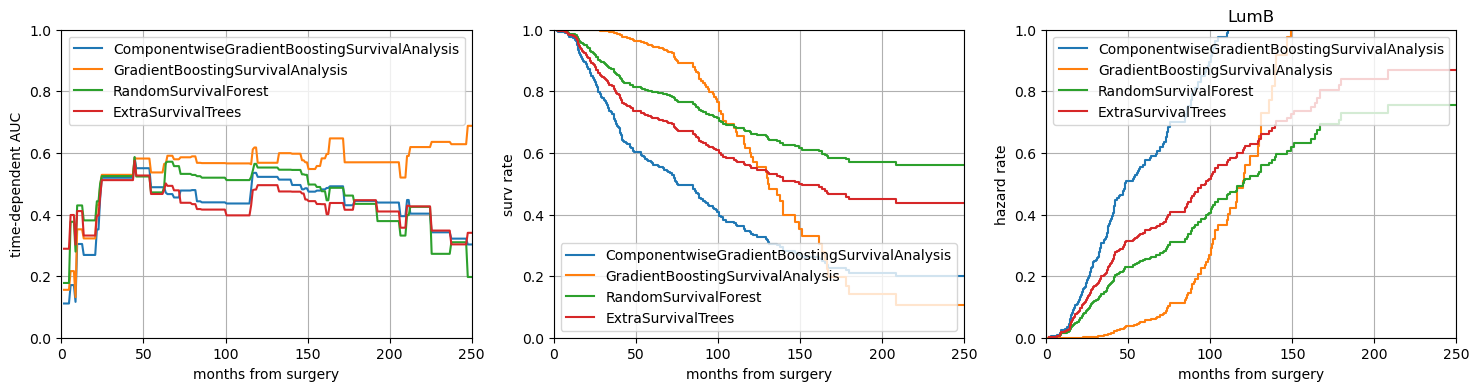

subgroup:  Her2


(196, 139)

(196,)

(22, 139)

(22,)

(196, 139)

(196,)

(22, 139)

(22,)

(196, 139)

(196,)

(22, 139)

(22,)

(196, 139)

(196,)

(22, 139)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.874   
test c-index                                           0.370   
AUC mean                                               0.268   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                              1.00                 0.921   
test c-index                               0.40                 0.309   
AUC mean                                   0.34                 0.233   

               ExtraSurvivalTrees  
train c-index               0.928  
test c-index                0.345  
AUC mean                    0.279

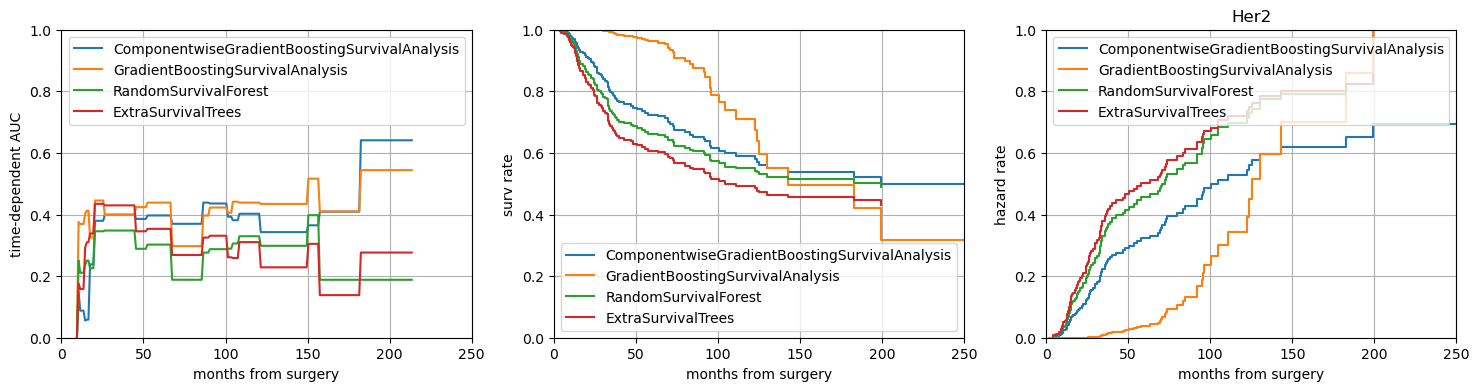

subgroup:  Normal


(126, 90)

(126,)

(14, 90)

(14,)

(126, 90)

(126,)

(14, 90)

(14,)

(126, 90)

(126,)

(14, 90)

(14,)

(126, 90)

(126,)

(14, 90)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.895   
test c-index                                           0.533   
AUC mean                                               0.525   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.924   
test c-index                              0.583                 0.583   
AUC mean                                  0.618                 0.576   

               ExtraSurvivalTrees  
train c-index               0.910  
test c-index                0.533  
AUC mean                    0.496

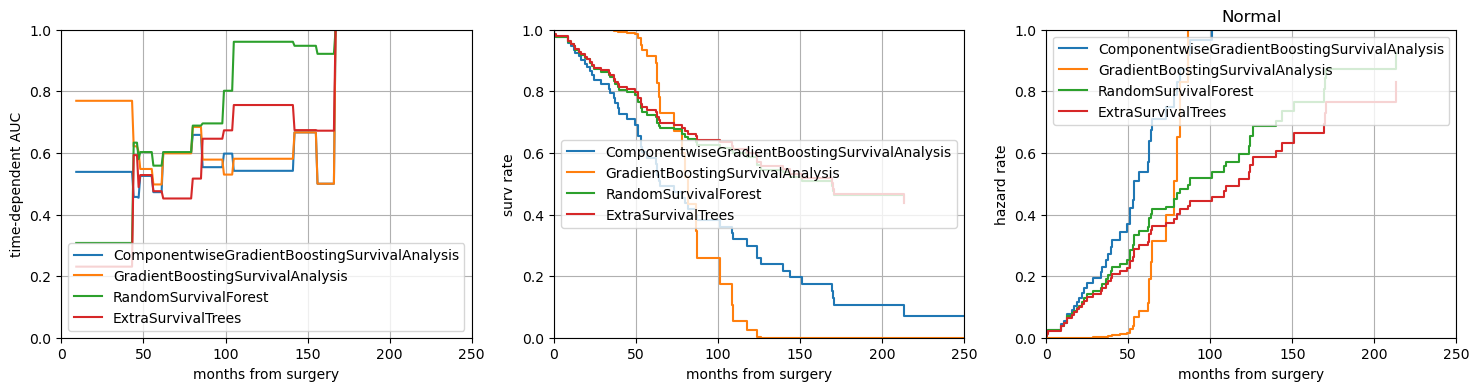

subgroup:  Basal


(179, 129)

(179,)

(20, 129)

(20,)

(179, 129)

(179,)

(20, 129)

(20,)

(179, 129)

(179,)

(20, 129)

(20,)

(179, 129)

(179,)

(20, 129)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.854   
test c-index                                           0.320   
AUC mean                                               0.259   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.933   
test c-index                              0.377                 0.287   
AUC mean                                  0.299                 0.174   

               ExtraSurvivalTrees  
train c-index               0.944  
test c-index                0.410  
AUC mean                    0.280

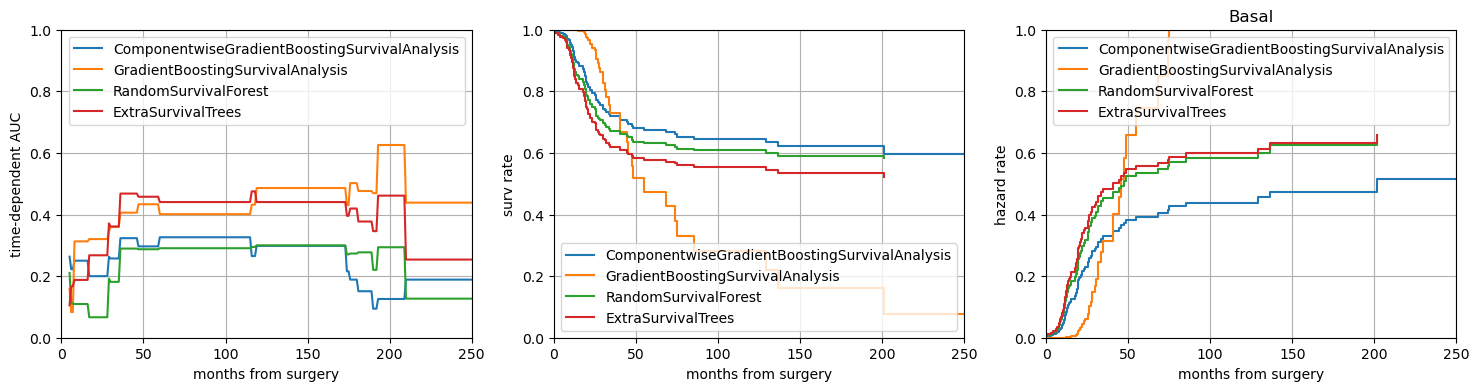

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

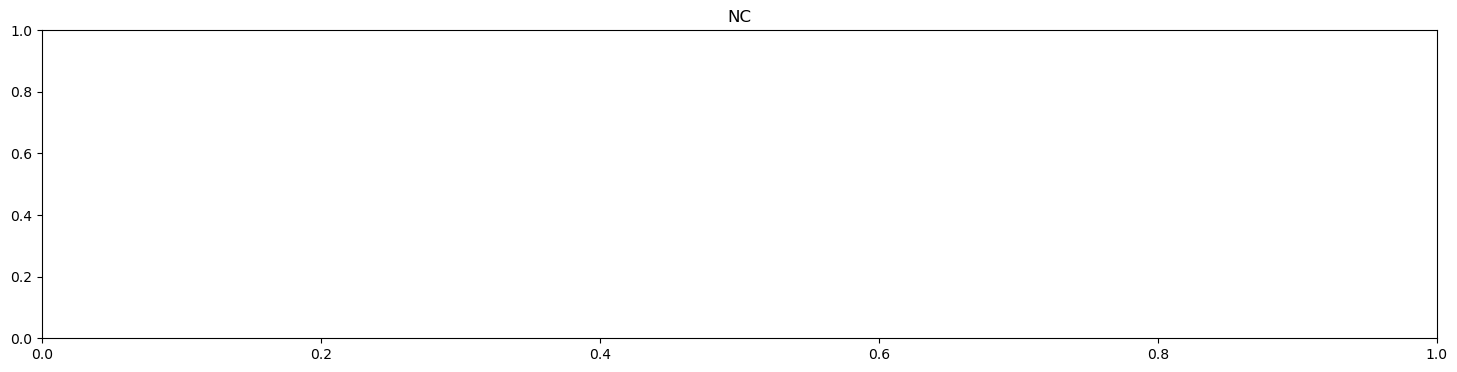

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
87
subgroup:  claudin-low


(177, 127)

(177,)

(20, 127)

(20,)

(177, 127)

(177,)

(20, 127)

(20,)

(177, 127)

(177,)

(20, 127)

(20,)

(177, 127)

(177,)

(20, 127)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.911   
test c-index                                           0.663   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.937   
test c-index                              0.629                 0.674   
AUC mean                                  0.637                 0.658   

               ExtraSurvivalTrees  
train c-index               0.941  
test c-index                0.663  
AUC mean                    0.683

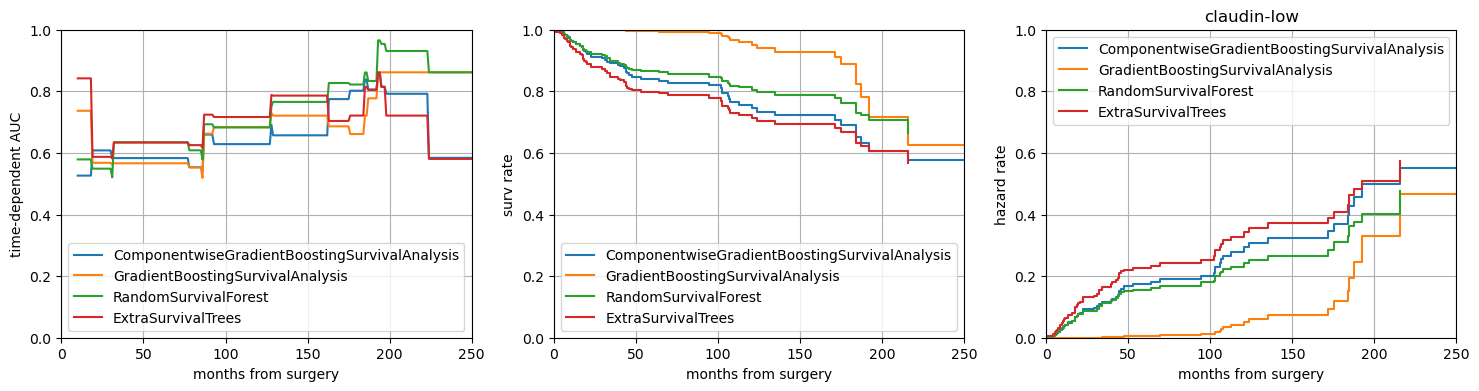

subgroup:  LumA


(605, 421)

(605,)

(68, 421)

(68,)

(605, 421)

(605,)

(68, 421)

(68,)

(605, 421)

(605,)

(68, 421)

(68,)

(605, 421)

(605,)

(68, 421)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.809   
test c-index                                           0.577   
AUC mean                                               0.640   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.997                 0.953   
test c-index                              0.425                 0.502   
AUC mean                                  0.436                 0.521   

               ExtraSurvivalTrees  
train c-index               0.958  
test c-index                0.421  
AUC mean                    0.459

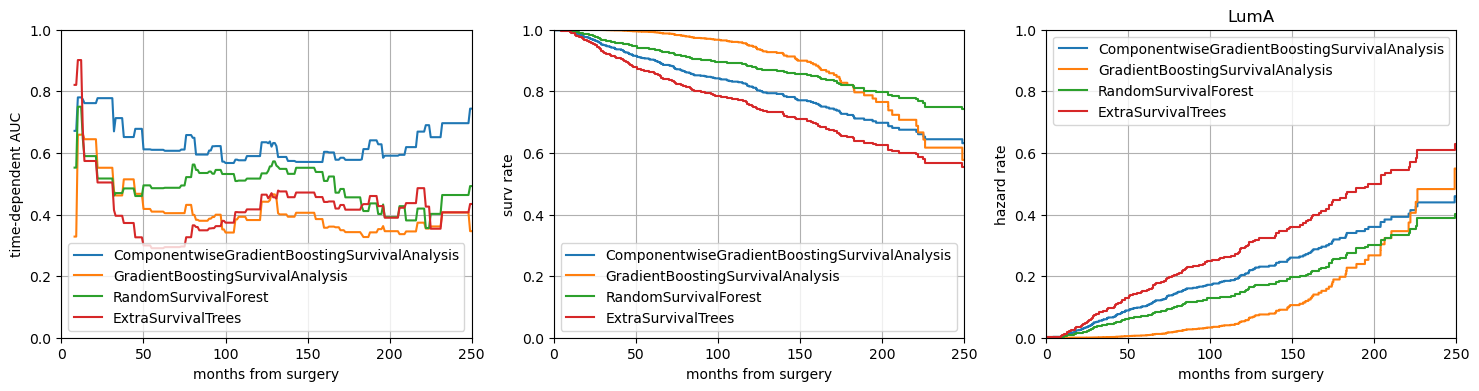

subgroup:  LumB


(414, 296)

(414,)

(46, 296)

(46,)

(414, 296)

(414,)

(46, 296)

(46,)

(414, 296)

(414,)

(46, 296)

(46,)

(414, 296)

(414,)

(46, 296)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.840   
test c-index                                           0.485   
AUC mean                                               0.419   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.925   
test c-index                              0.550                 0.510   
AUC mean                                  0.495                 0.464   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.546  
AUC mean                    0.521

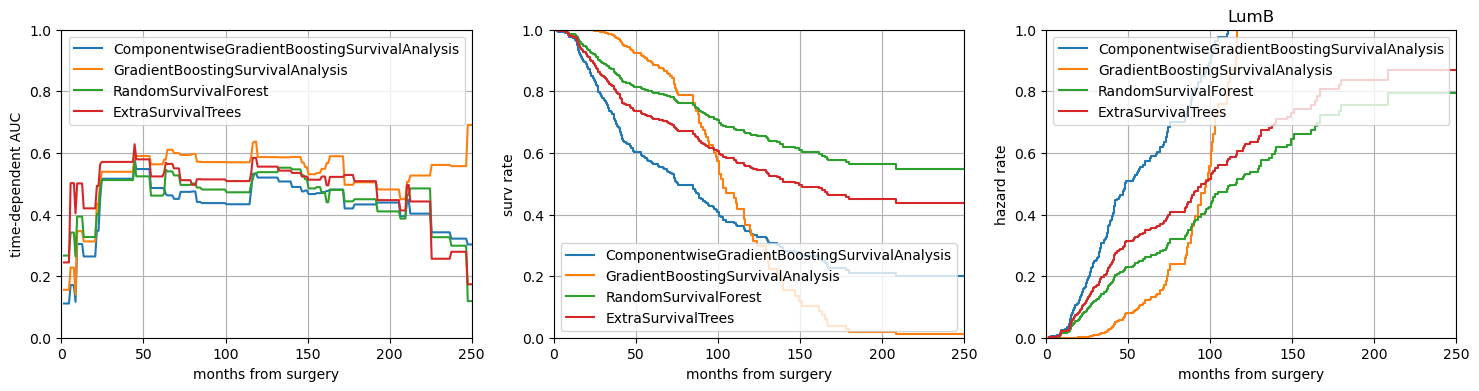

subgroup:  Her2


(196, 143)

(196,)

(22, 143)

(22,)

(196, 143)

(196,)

(22, 143)

(22,)

(196, 143)

(196,)

(22, 143)

(22,)

(196, 143)

(196,)

(22, 143)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.879   
test c-index                                           0.339   
AUC mean                                               0.253   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.923   
test c-index                              0.430                 0.273   
AUC mean                                  0.385                 0.196   

               ExtraSurvivalTrees  
train c-index               0.929  
test c-index                0.352  
AUC mean                    0.289

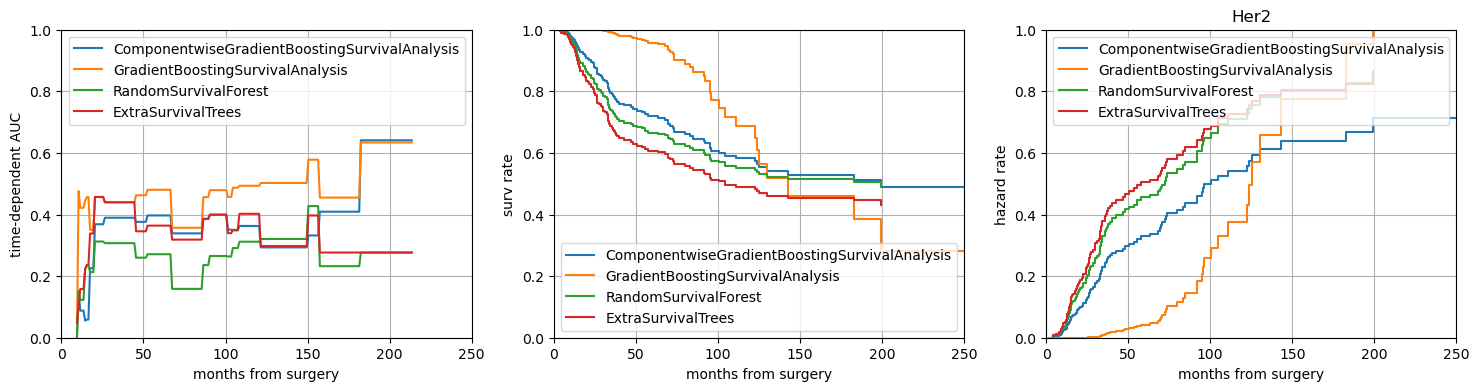

subgroup:  Normal


(126, 92)

(126,)

(14, 92)

(14,)

(126, 92)

(126,)

(14, 92)

(14,)

(126, 92)

(126,)

(14, 92)

(14,)

(126, 92)

(126,)

(14, 92)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.899   
test c-index                                           0.533   
AUC mean                                               0.525   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.924   
test c-index                              0.583                 0.717   
AUC mean                                  0.632                 0.670   

               ExtraSurvivalTrees  
train c-index               0.921  
test c-index                0.650  
AUC mean                    0.676

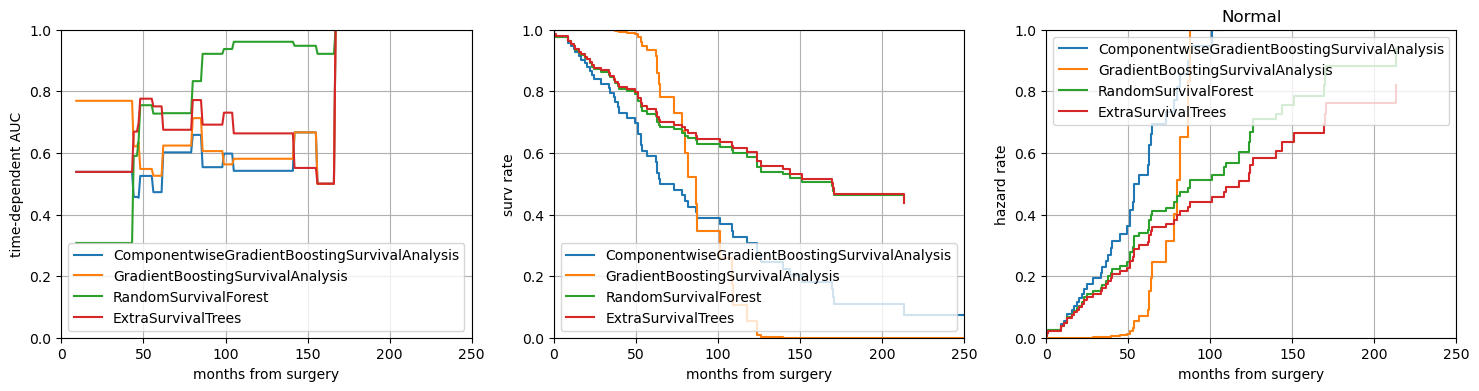

subgroup:  Basal


(179, 132)

(179,)

(20, 132)

(20,)

(179, 132)

(179,)

(20, 132)

(20,)

(179, 132)

(179,)

(20, 132)

(20,)

(179, 132)

(179,)

(20, 132)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.860   
test c-index                                           0.320   
AUC mean                                               0.259   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.311                 0.254   
AUC mean                                  0.229                 0.123   

               ExtraSurvivalTrees  
train c-index               0.930  
test c-index                0.402  
AUC mean                    0.246

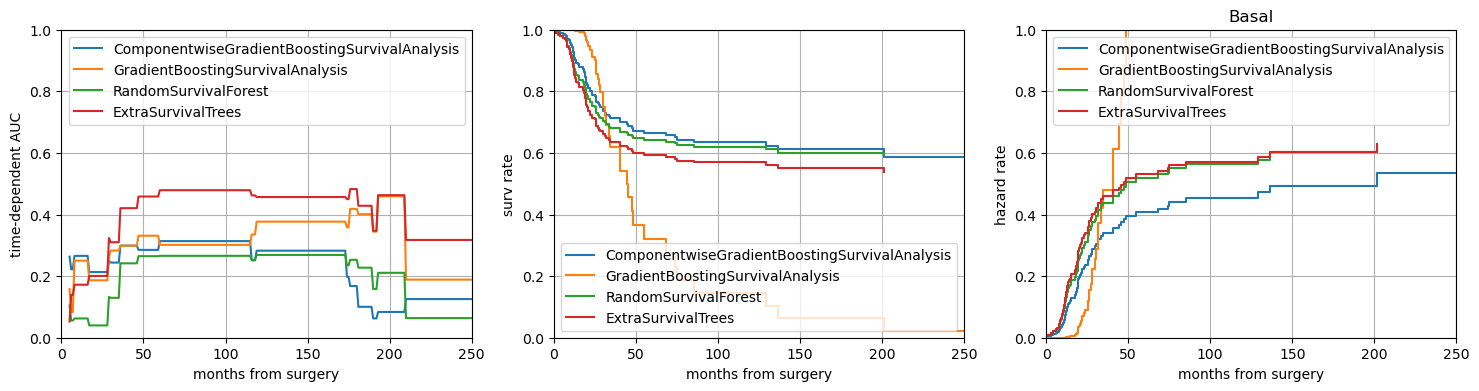

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

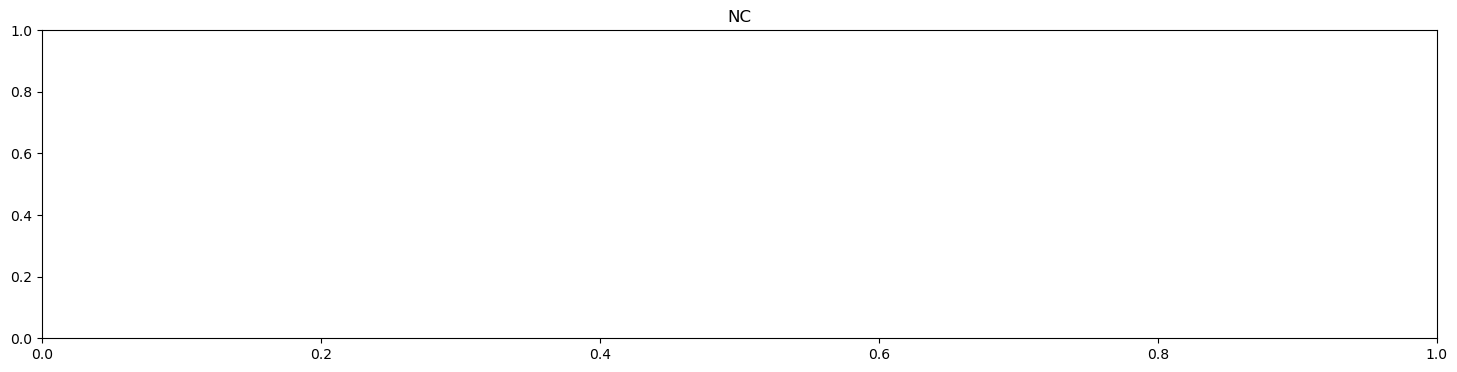

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
88
subgroup:  claudin-low


(177, 130)

(177,)

(20, 130)

(20,)

(177, 130)

(177,)

(20, 130)

(20,)

(177, 130)

(177,)

(20, 130)

(20,)

(177, 130)

(177,)

(20, 130)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.911   
test c-index                                           0.663   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.933   
test c-index                              0.618                 0.719   
AUC mean                                  0.614                 0.729   

               ExtraSurvivalTrees  
train c-index               0.944  
test c-index                0.596  
AUC mean                    0.594

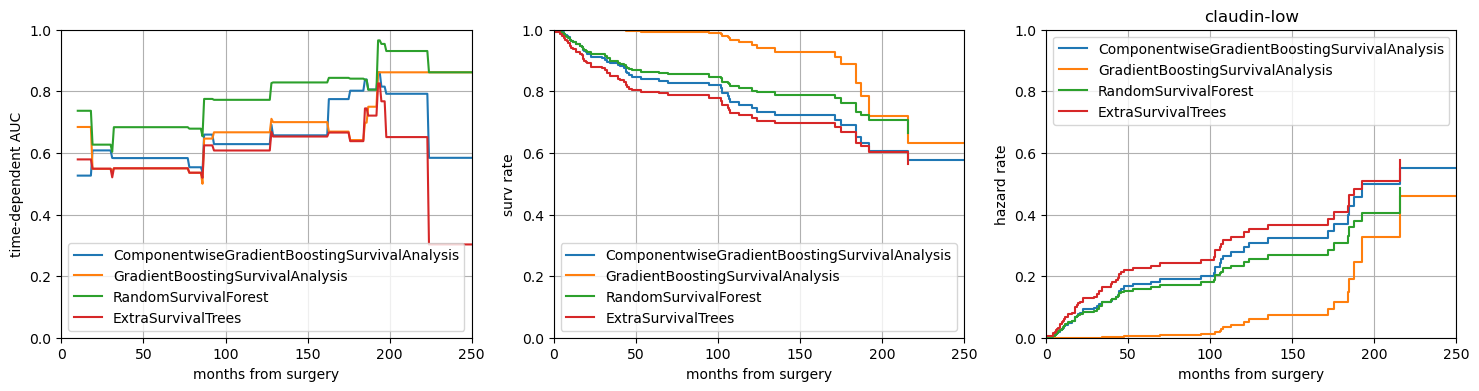

subgroup:  LumA


(605, 433)

(605,)

(68, 433)

(68,)

(605, 433)

(605,)

(68, 433)

(68,)

(605, 433)

(605,)

(68, 433)

(68,)

(605, 433)

(605,)

(68, 433)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.814   
test c-index                                           0.581   
AUC mean                                               0.642   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.953   
test c-index                              0.460                 0.516   
AUC mean                                  0.479                 0.565   

               ExtraSurvivalTrees  
train c-index               0.960  
test c-index                0.531  
AUC mean                    0.597

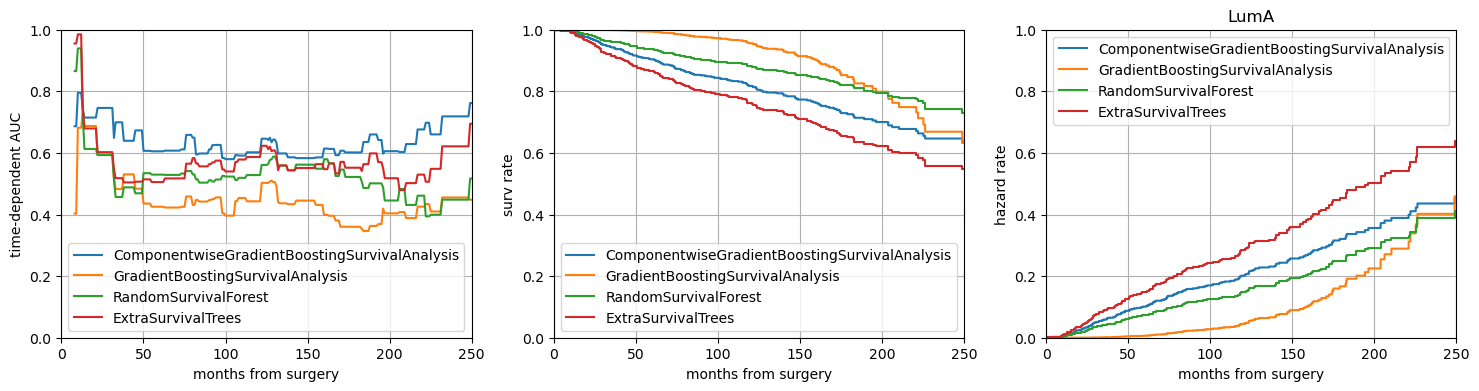

subgroup:  LumB


(414, 303)

(414,)

(46, 303)

(46,)

(414, 303)

(414,)

(46, 303)

(46,)

(414, 303)

(414,)

(46, 303)

(46,)

(414, 303)

(414,)

(46, 303)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.843   
test c-index                                           0.492   
AUC mean                                               0.428   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.928   
test c-index                              0.550                 0.522   
AUC mean                                  0.494                 0.478   

               ExtraSurvivalTrees  
train c-index               0.930  
test c-index                0.490  
AUC mean                    0.452

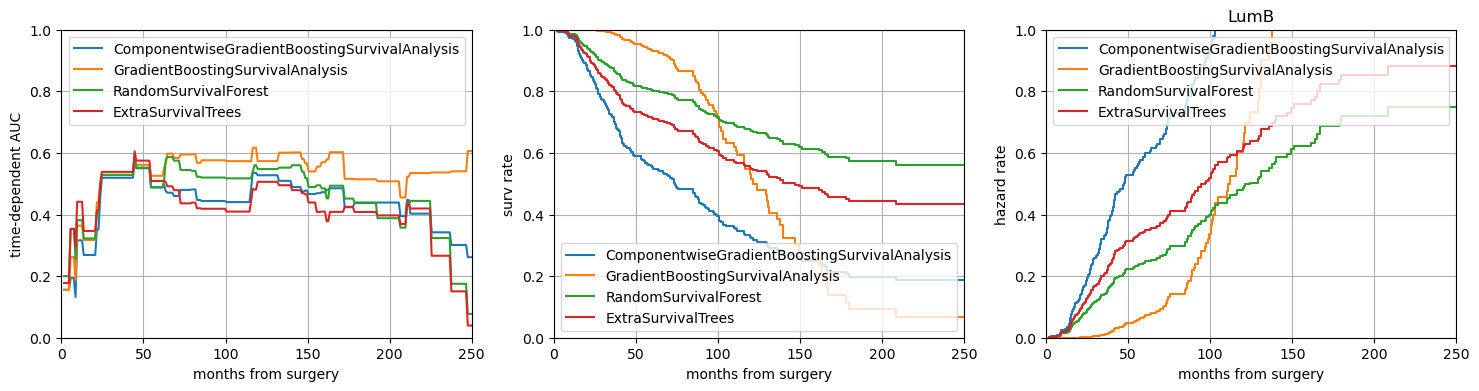

subgroup:  Her2


(196, 147)

(196,)

(22, 147)

(22,)

(196, 147)

(196,)

(22, 147)

(22,)

(196, 147)

(196,)

(22, 147)

(22,)

(196, 147)

(196,)

(22, 147)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.879   
test c-index                                           0.327   
AUC mean                                               0.246   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.922   
test c-index                              0.442                 0.291   
AUC mean                                  0.389                 0.217   

               ExtraSurvivalTrees  
train c-index               0.925  
test c-index                0.327  
AUC mean                    0.281

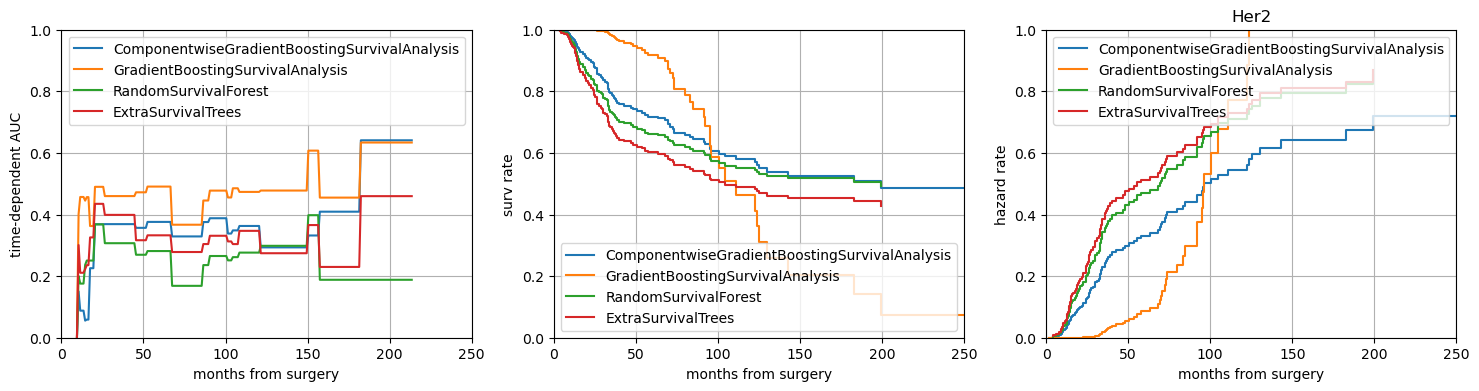

subgroup:  Normal


(126, 95)

(126,)

(14, 95)

(14,)

(126, 95)

(126,)

(14, 95)

(14,)

(126, 95)

(126,)

(14, 95)

(14,)

(126, 95)

(126,)

(14, 95)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.899   
test c-index                                           0.533   
AUC mean                                               0.525   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.927   
test c-index                              0.633                 0.750   
AUC mean                                  0.682                 0.810   

               ExtraSurvivalTrees  
train c-index               0.922  
test c-index                0.583  
AUC mean                    0.592

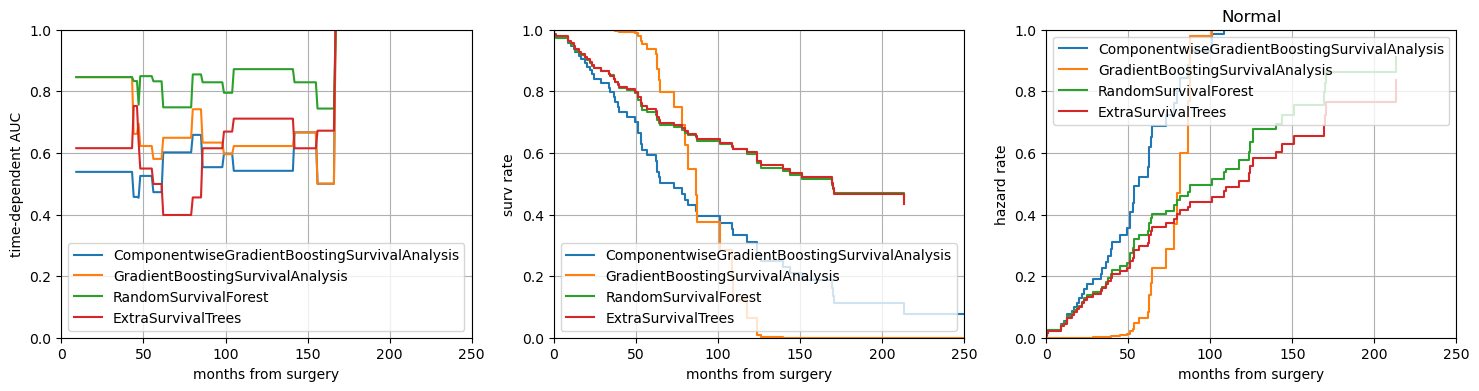

subgroup:  Basal


(179, 135)

(179,)

(20, 135)

(20,)

(179, 135)

(179,)

(20, 135)

(20,)

(179, 135)

(179,)

(20, 135)

(20,)

(179, 135)

(179,)

(20, 135)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.860   
test c-index                                           0.320   
AUC mean                                               0.259   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.934   
test c-index                              0.385                 0.238   
AUC mean                                  0.312                 0.111   

               ExtraSurvivalTrees  
train c-index               0.930  
test c-index                0.336  
AUC mean                    0.247

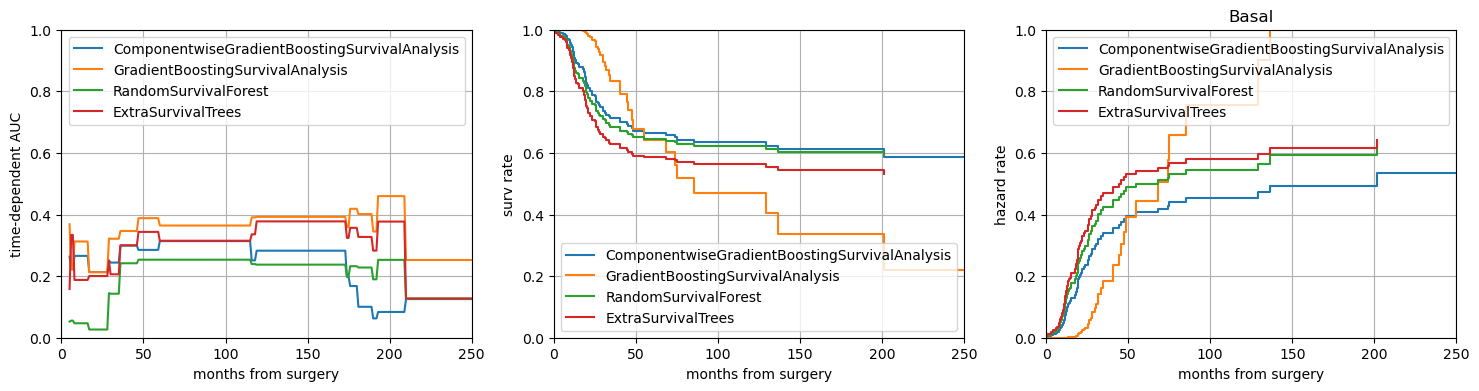

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

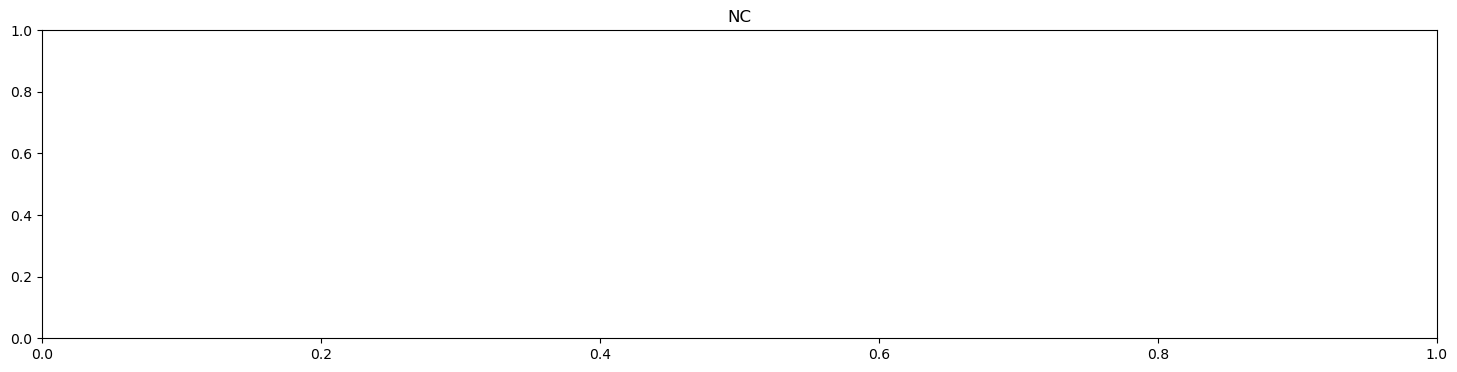

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
89
subgroup:  claudin-low


(177, 134)

(177,)

(20, 134)

(20,)

(177, 134)

(177,)

(20, 134)

(20,)

(177, 134)

(177,)

(20, 134)

(20,)

(177, 134)

(177,)

(20, 134)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.911   
test c-index                                           0.663   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.607                 0.652   
AUC mean                                  0.619                 0.642   

               ExtraSurvivalTrees  
train c-index               0.938  
test c-index                0.652  
AUC mean                    0.618

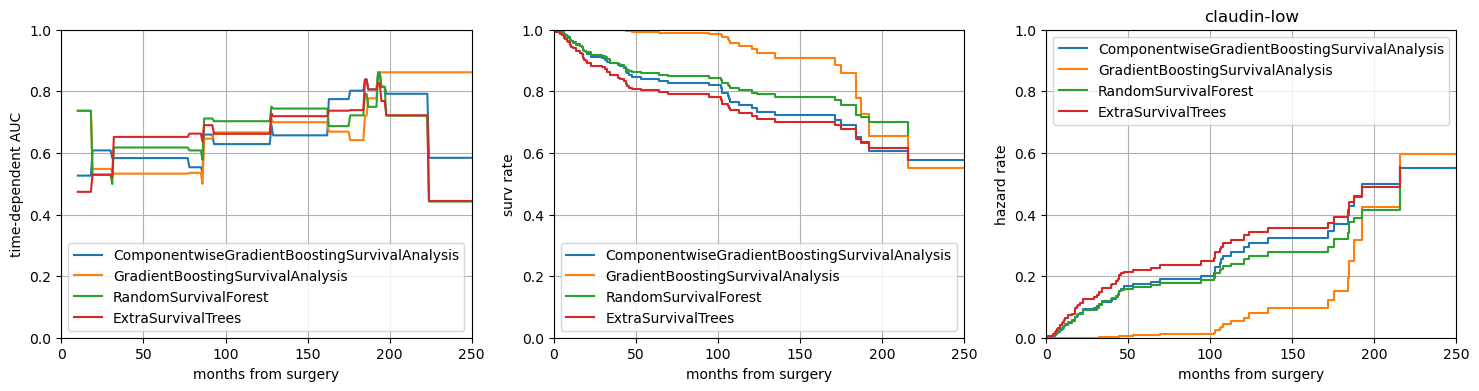

subgroup:  LumA


(605, 446)

(605,)

(68, 446)

(68,)

(605, 446)

(605,)

(68, 446)

(68,)

(605, 446)

(605,)

(68, 446)

(68,)

(605, 446)

(605,)

(68, 446)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.815   
test c-index                                           0.584   
AUC mean                                               0.644   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.997                 0.955   
test c-index                              0.444                 0.510   
AUC mean                                  0.468                 0.550   

               ExtraSurvivalTrees  
train c-index               0.958  
test c-index                0.511  
AUC mean                    0.578

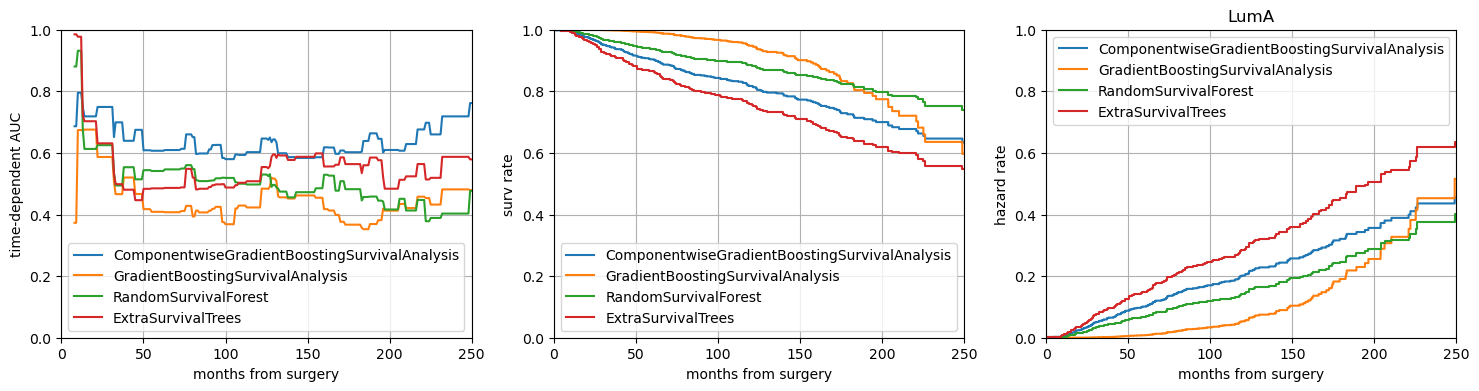

subgroup:  LumB


(414, 312)

(414,)

(46, 312)

(46,)

(414, 312)

(414,)

(46, 312)

(46,)

(414, 312)

(414,)

(46, 312)

(46,)

(414, 312)

(414,)

(46, 312)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.843   
test c-index                                           0.490   
AUC mean                                               0.423   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.926   
test c-index                              0.546                 0.519   
AUC mean                                  0.492                 0.481   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.449  
AUC mean                    0.373

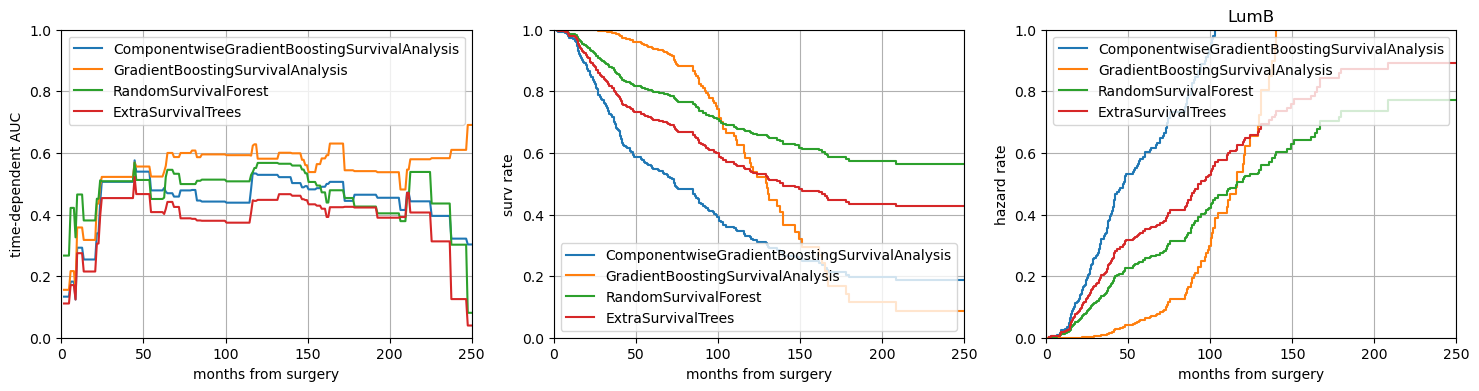

subgroup:  Her2


(196, 150)

(196,)

(22, 150)

(22,)

(196, 150)

(196,)

(22, 150)

(22,)

(196, 150)

(196,)

(22, 150)

(22,)

(196, 150)

(196,)

(22, 150)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.879   
test c-index                                           0.327   
AUC mean                                               0.246   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.922   
test c-index                              0.448                 0.327   
AUC mean                                  0.397                 0.262   

               ExtraSurvivalTrees  
train c-index               0.922  
test c-index                0.285  
AUC mean                    0.227

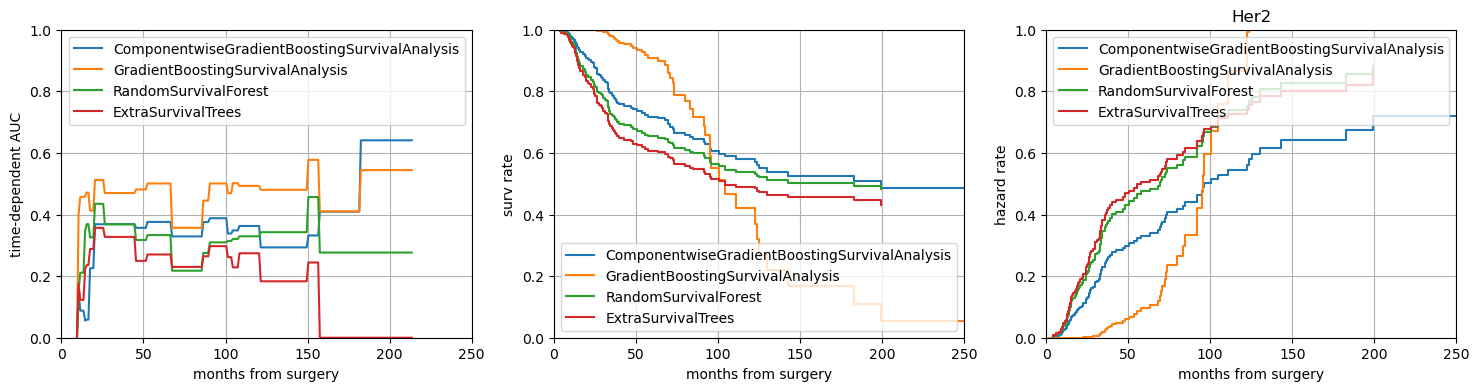

subgroup:  Normal


(126, 97)

(126,)

(14, 97)

(14,)

(126, 97)

(126,)

(14, 97)

(14,)

(126, 97)

(126,)

(14, 97)

(14,)

(126, 97)

(126,)

(14, 97)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.901   
test c-index                                           0.533   
AUC mean                                               0.525   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.929   
test c-index                              0.600                 0.683   
AUC mean                                  0.659                 0.707   

               ExtraSurvivalTrees  
train c-index               0.917  
test c-index                0.600  
AUC mean                    0.575

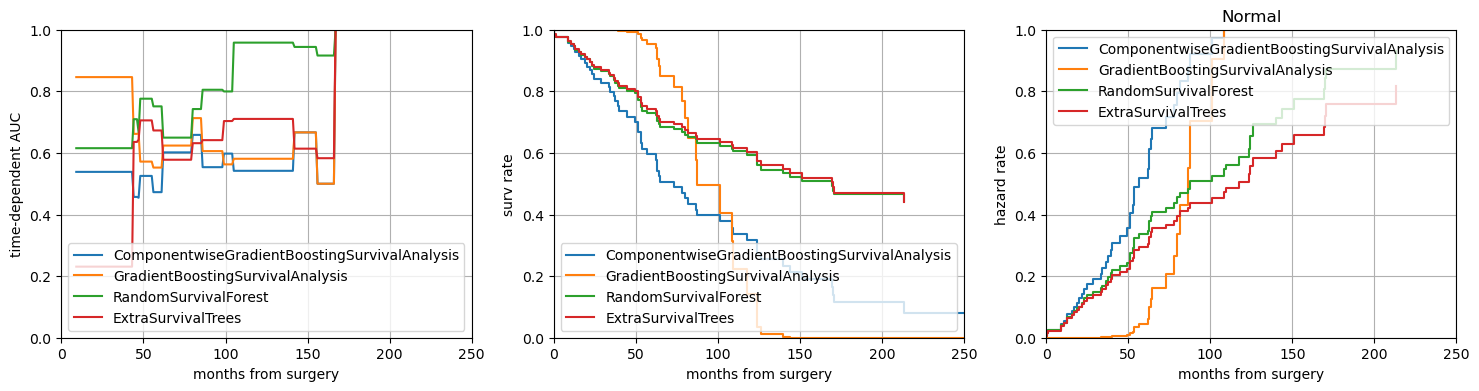

subgroup:  Basal


(179, 139)

(179,)

(20, 139)

(20,)

(179, 139)

(179,)

(20, 139)

(20,)

(179, 139)

(179,)

(20, 139)

(20,)

(179, 139)

(179,)

(20, 139)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.863   
test c-index                                           0.336   
AUC mean                                               0.273   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.935   
test c-index                              0.385                 0.262   
AUC mean                                  0.327                 0.124   

               ExtraSurvivalTrees  
train c-index               0.934  
test c-index                0.393  
AUC mean                    0.252

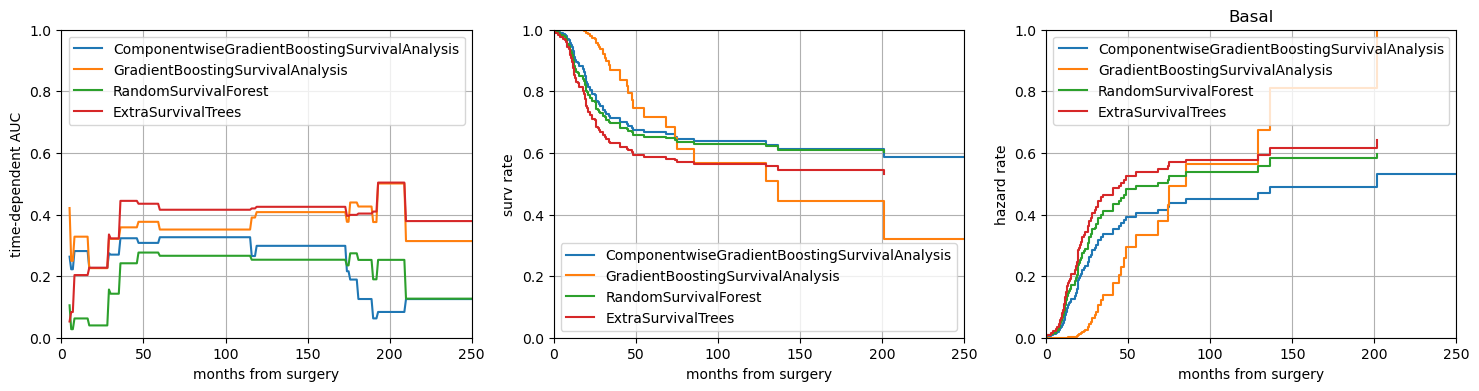

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

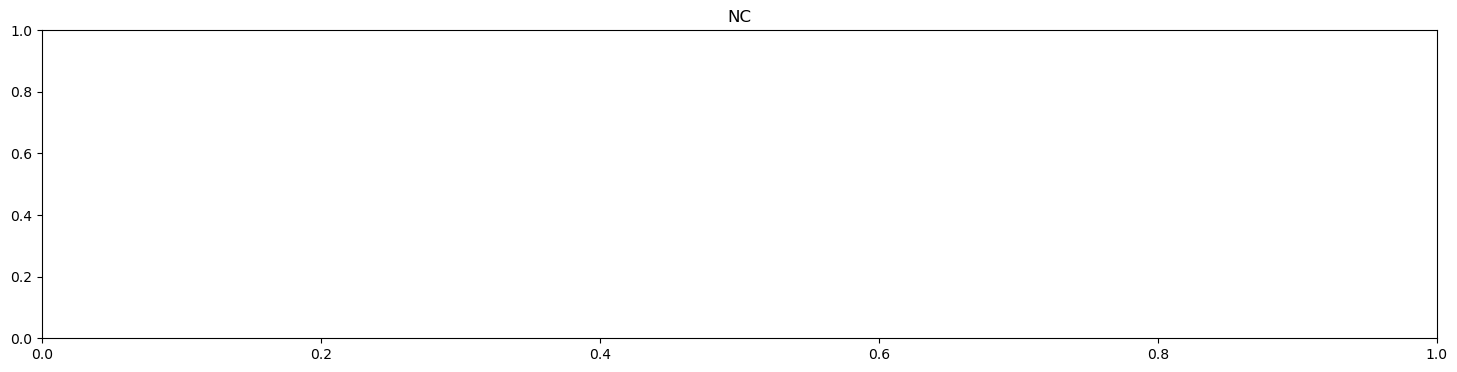

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
90
subgroup:  claudin-low


(177, 137)

(177,)

(20, 137)

(20,)

(177, 137)

(177,)

(20, 137)

(20,)

(177, 137)

(177,)

(20, 137)

(20,)

(177, 137)

(177,)

(20, 137)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.911   
test c-index                                           0.629   
AUC mean                                               0.592   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.938   
test c-index                              0.607                 0.674   
AUC mean                                  0.626                 0.690   

               ExtraSurvivalTrees  
train c-index               0.940  
test c-index                0.697  
AUC mean                    0.716

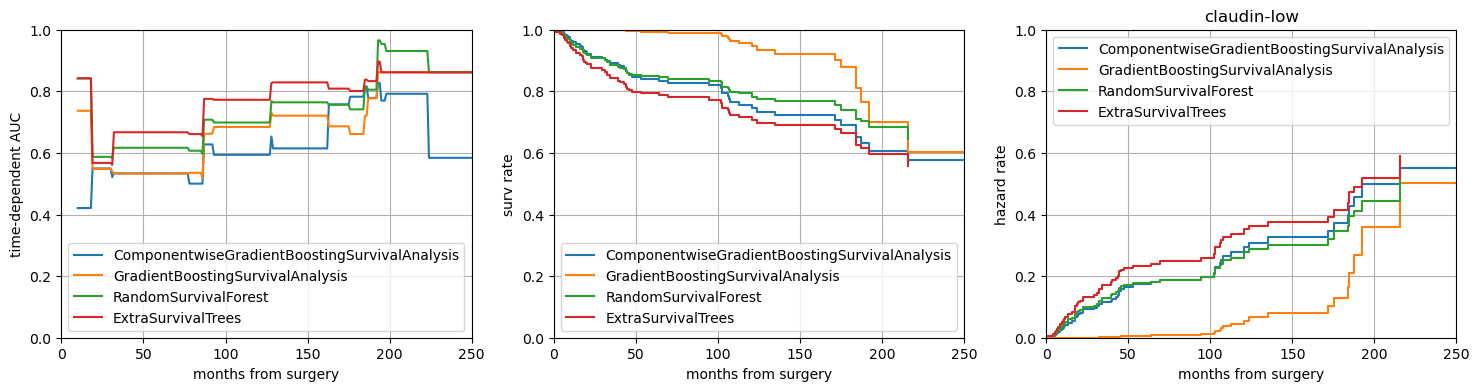

subgroup:  LumA


(605, 458)

(605,)

(68, 458)

(68,)

(605, 458)

(605,)

(68, 458)

(68,)

(605, 458)

(605,)

(68, 458)

(68,)

(605, 458)

(605,)

(68, 458)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.814   
test c-index                                           0.583   
AUC mean                                               0.641   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.997                 0.956   
test c-index                              0.430                 0.547   
AUC mean                                  0.468                 0.581   

               ExtraSurvivalTrees  
train c-index               0.961  
test c-index                0.562  
AUC mean                    0.617

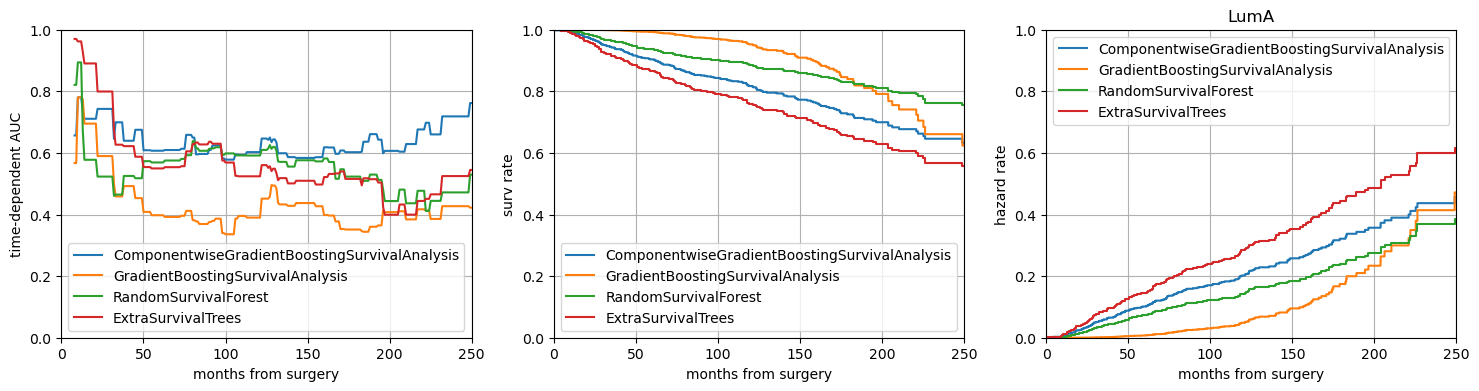

subgroup:  LumB


(414, 320)

(414,)

(46, 320)

(46,)

(414, 320)

(414,)

(46, 320)

(46,)

(414, 320)

(414,)

(46, 320)

(46,)

(414, 320)

(414,)

(46, 320)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.844   
test c-index                                           0.494   
AUC mean                                               0.428   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.931   
test c-index                              0.522                 0.528   
AUC mean                                  0.474                 0.479   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.438  
AUC mean                    0.387

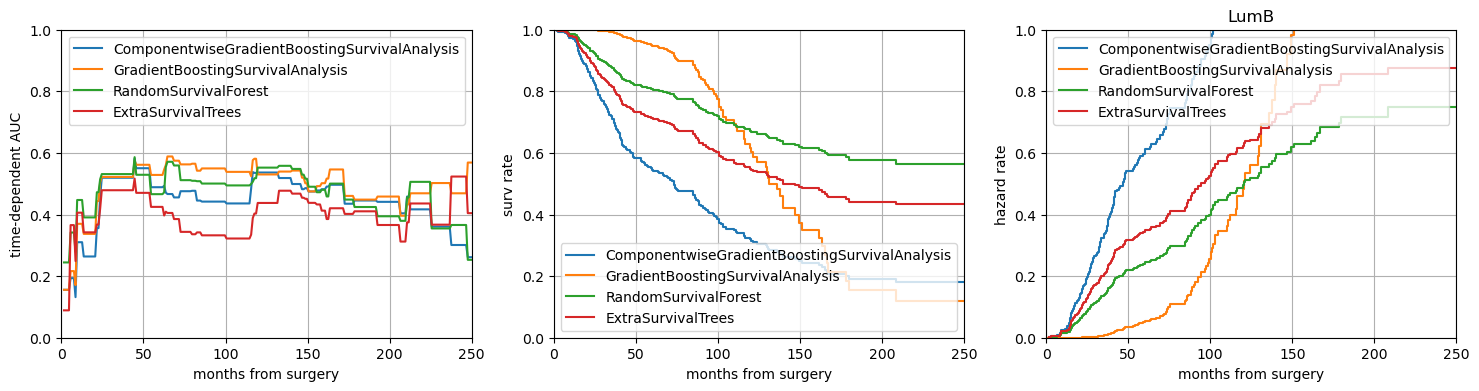

subgroup:  Her2


(196, 154)

(196,)

(22, 154)

(22,)

(196, 154)

(196,)

(22, 154)

(22,)

(196, 154)

(196,)

(22, 154)

(22,)

(196, 154)

(196,)

(22, 154)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.878   
test c-index                                           0.339   
AUC mean                                               0.254   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.924   
test c-index                              0.455                 0.327   
AUC mean                                  0.414                 0.259   

               ExtraSurvivalTrees  
train c-index               0.929  
test c-index                0.327  
AUC mean                    0.277

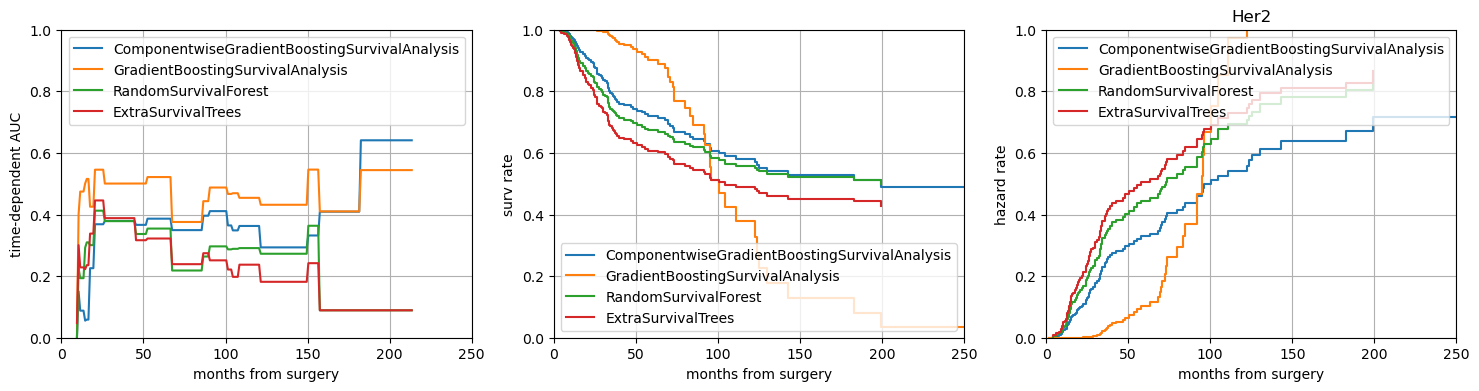

subgroup:  Normal


(126, 99)

(126,)

(14, 99)

(14,)

(126, 99)

(126,)

(14, 99)

(14,)

(126, 99)

(126,)

(14, 99)

(14,)

(126, 99)

(126,)

(14, 99)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.908   
test c-index                                           0.550   
AUC mean                                               0.561   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.926   
test c-index                              0.633                 0.617   
AUC mean                                  0.661                 0.617   

               ExtraSurvivalTrees  
train c-index               0.926  
test c-index                0.500  
AUC mean                    0.485

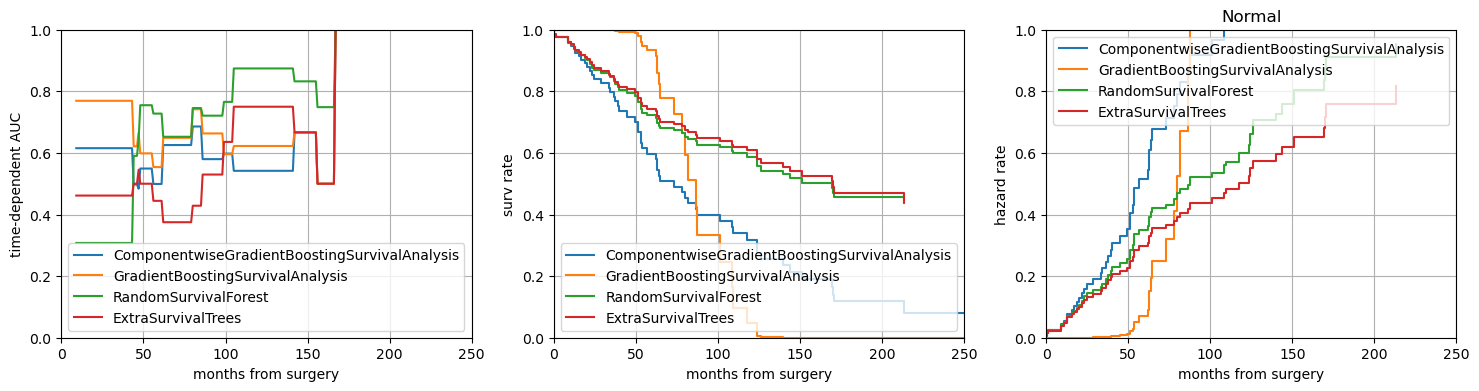

subgroup:  Basal


(179, 142)

(179,)

(20, 142)

(20,)

(179, 142)

(179,)

(20, 142)

(20,)

(179, 142)

(179,)

(20, 142)

(20,)

(179, 142)

(179,)

(20, 142)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.868   
test c-index                                           0.328   
AUC mean                                               0.284   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.930   
test c-index                              0.369                 0.262   
AUC mean                                  0.330                 0.138   

               ExtraSurvivalTrees  
train c-index               0.936  
test c-index                0.246  
AUC mean                    0.165

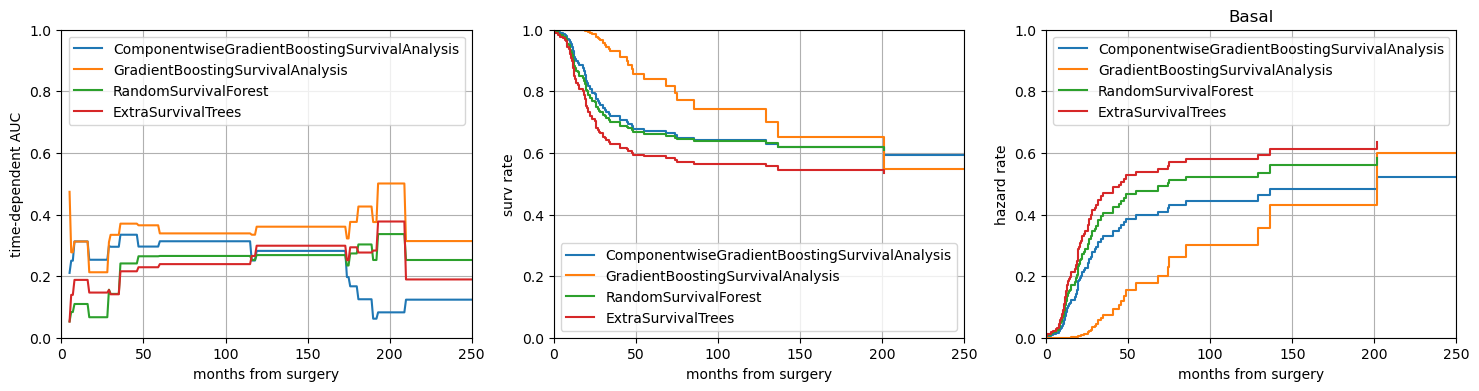

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

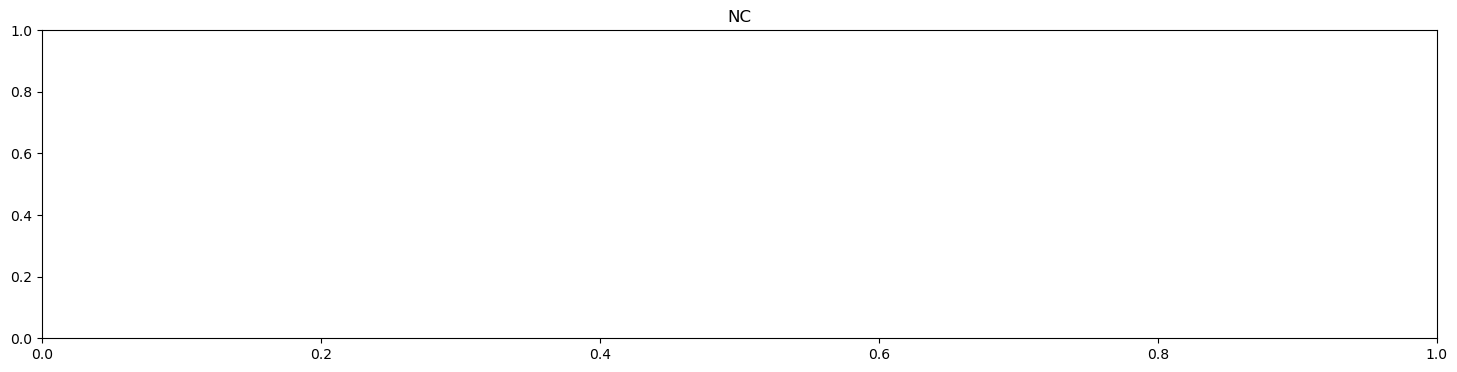

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
91
subgroup:  claudin-low


(177, 141)

(177,)

(20, 141)

(20,)

(177, 141)

(177,)

(20, 141)

(20,)

(177, 141)

(177,)

(20, 141)

(20,)

(177, 141)

(177,)

(20, 141)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.911   
test c-index                                           0.629   
AUC mean                                               0.592   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.936   
test c-index                              0.584                 0.685   
AUC mean                                  0.602                 0.684   

               ExtraSurvivalTrees  
train c-index               0.947  
test c-index                0.652  
AUC mean                    0.619

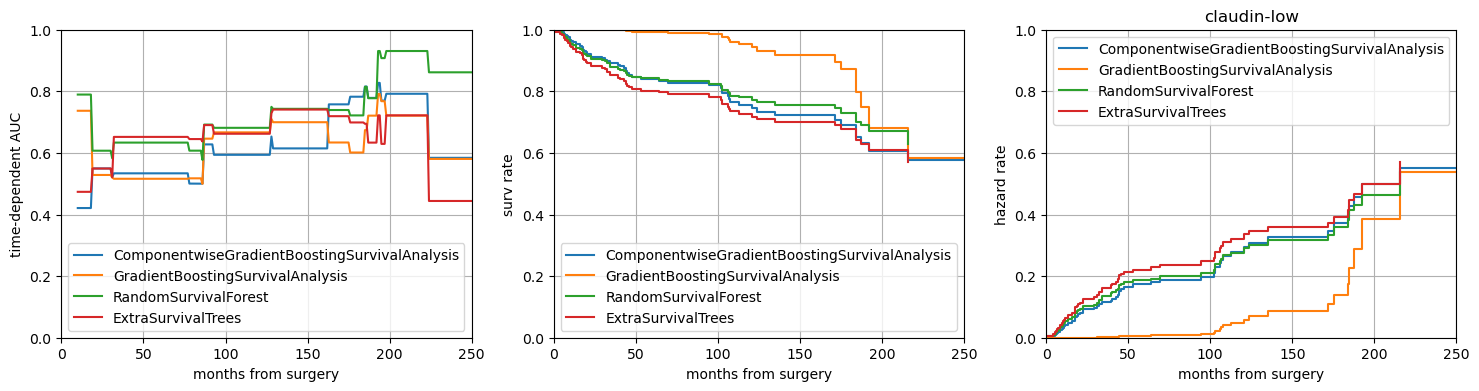

subgroup:  LumA


(605, 471)

(605,)

(68, 471)

(68,)

(605, 471)

(605,)

(68, 471)

(68,)

(605, 471)

(605,)

(68, 471)

(68,)

(605, 471)

(605,)

(68, 471)

(68,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.818   
test c-index                                           0.588   
AUC mean                                               0.652   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.997                 0.955   
test c-index                              0.406                 0.540   
AUC mean                                  0.424                 0.578   

               ExtraSurvivalTrees  
train c-index               0.962  
test c-index                0.545  
AUC mean                    0.605

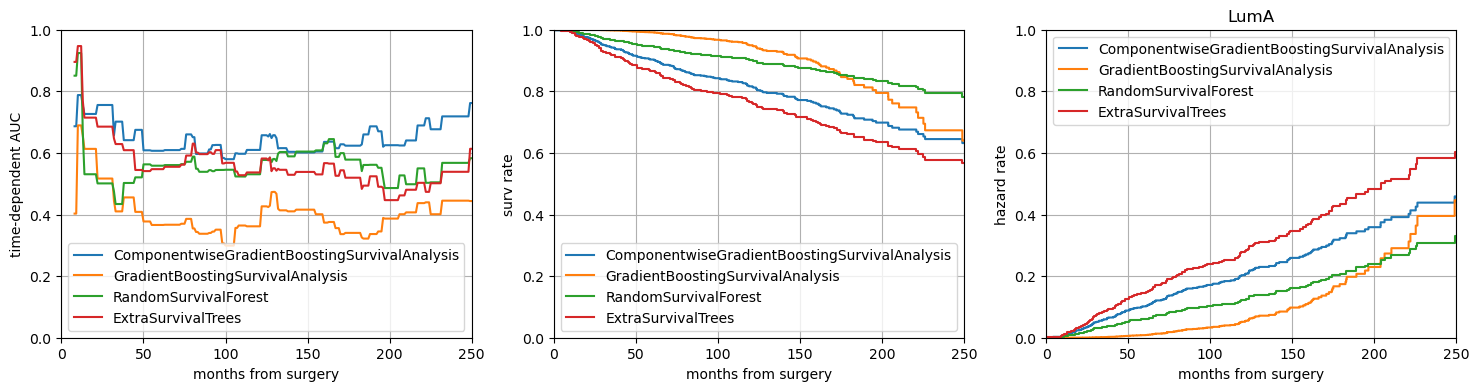

subgroup:  LumB


(414, 328)

(414,)

(46, 328)

(46,)

(414, 328)

(414,)

(46, 328)

(46,)

(414, 328)

(414,)

(46, 328)

(46,)

(414, 328)

(414,)

(46, 328)

(46,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.848   
test c-index                                           0.485   
AUC mean                                               0.422   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             0.998                 0.928   
test c-index                              0.510                 0.546   
AUC mean                                  0.466                 0.516   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.430  
AUC mean                    0.356

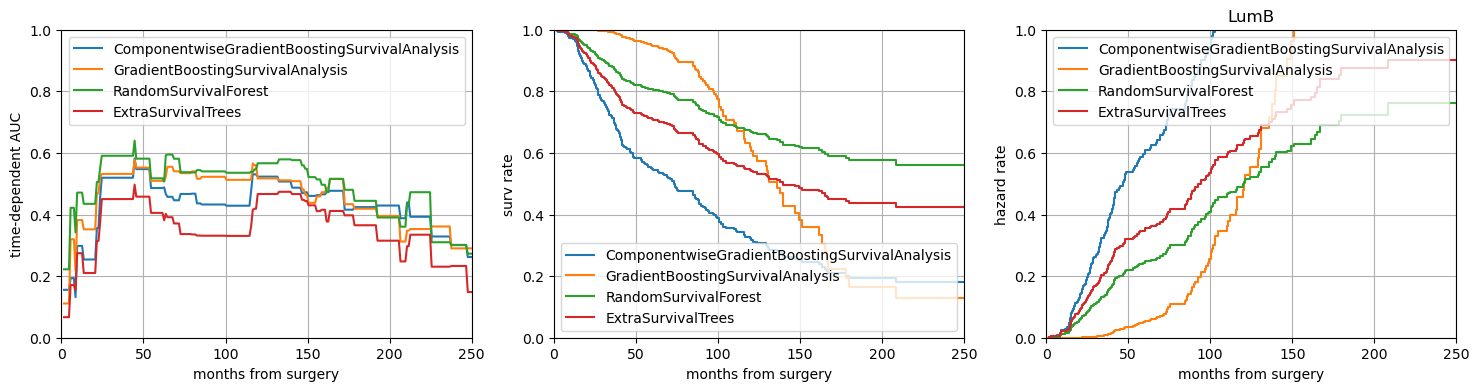

subgroup:  Her2


(196, 158)

(196,)

(22, 158)

(22,)

(196, 158)

(196,)

(22, 158)

(22,)

(196, 158)

(196,)

(22, 158)

(22,)

(196, 158)

(196,)

(22, 158)

(22,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.879   
test c-index                                           0.339   
AUC mean                                               0.254   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.923   
test c-index                              0.479                 0.376   
AUC mean                                  0.431                 0.335   

               ExtraSurvivalTrees  
train c-index               0.933  
test c-index                0.327  
AUC mean                    0.253

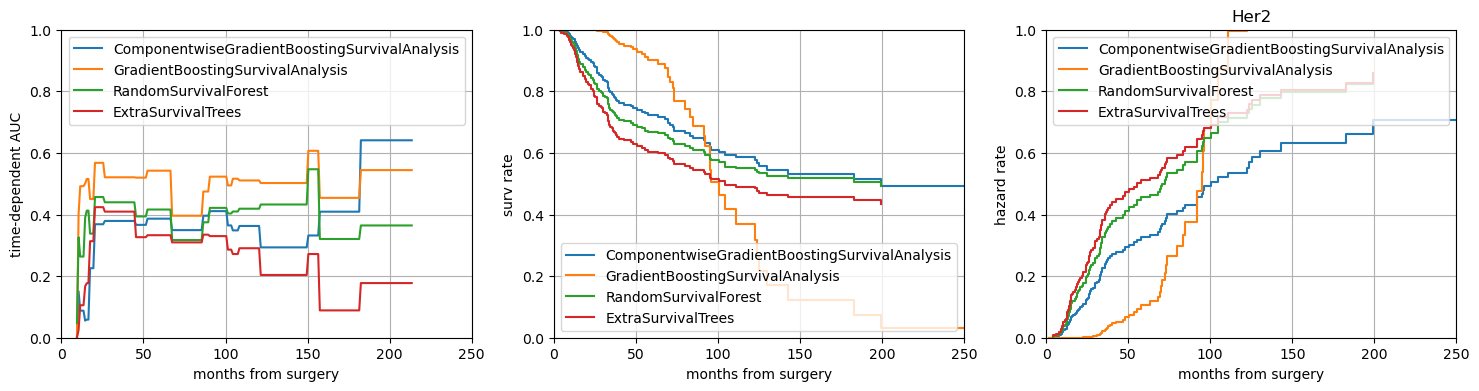

subgroup:  Normal


(126, 102)

(126,)

(14, 102)

(14,)

(126, 102)

(126,)

(14, 102)

(14,)

(126, 102)

(126,)

(14, 102)

(14,)

(126, 102)

(126,)

(14, 102)

(14,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.912   
test c-index                                           0.533   
AUC mean                                               0.525   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.932   
test c-index                              0.633                 0.717   
AUC mean                                  0.647                 0.739   

               ExtraSurvivalTrees  
train c-index               0.925  
test c-index                0.550  
AUC mean                    0.563

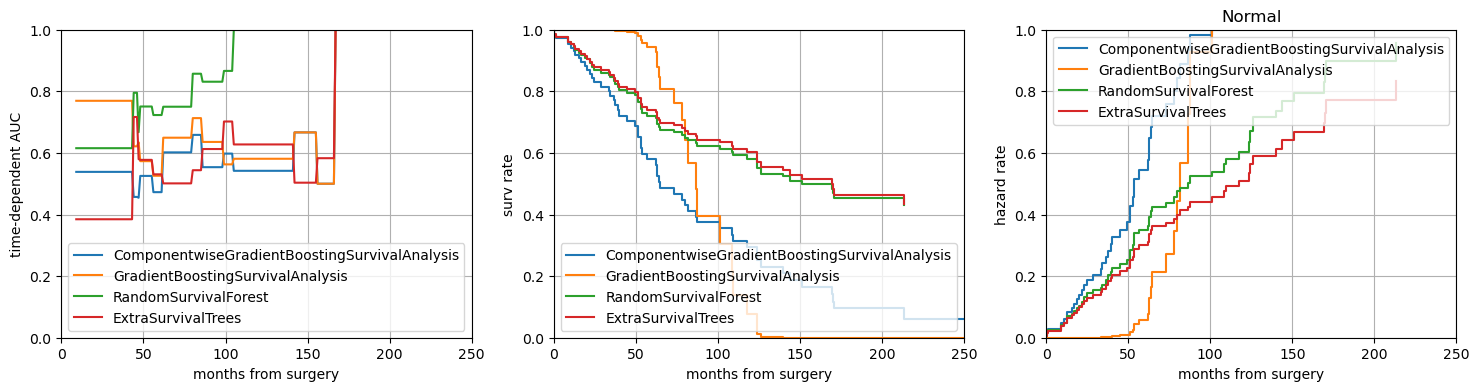

subgroup:  Basal


(179, 145)

(179,)

(20, 145)

(20,)

(179, 145)

(179,)

(20, 145)

(20,)

(179, 145)

(179,)

(20, 145)

(20,)

(179, 145)

(179,)

(20, 145)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.870   
test c-index                                           0.311   
AUC mean                                               0.257   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.931   
test c-index                              0.377                 0.287   
AUC mean                                  0.318                 0.177   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.336  
AUC mean                    0.220

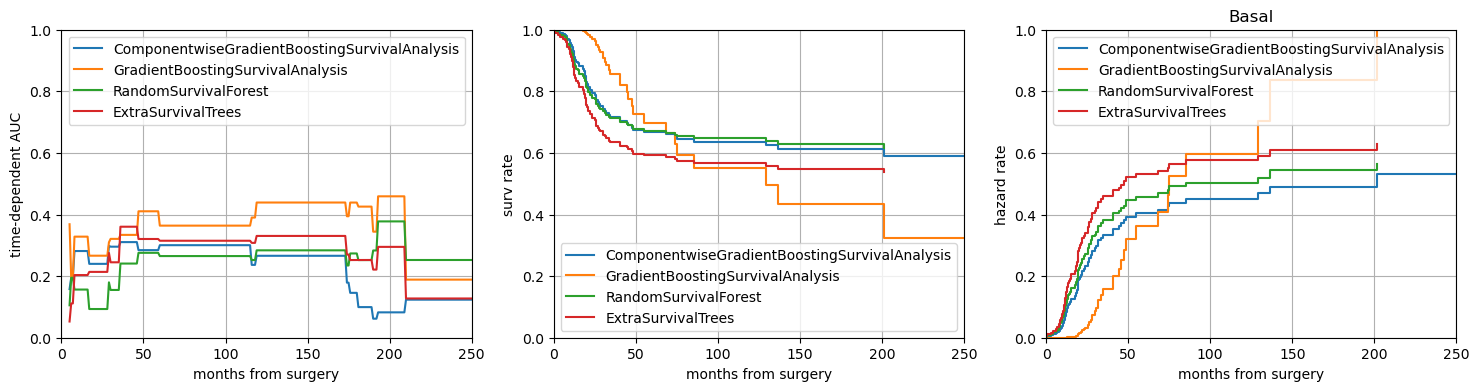

subgroup:  NC
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


Empty DataFrame
Columns: []
Index: []

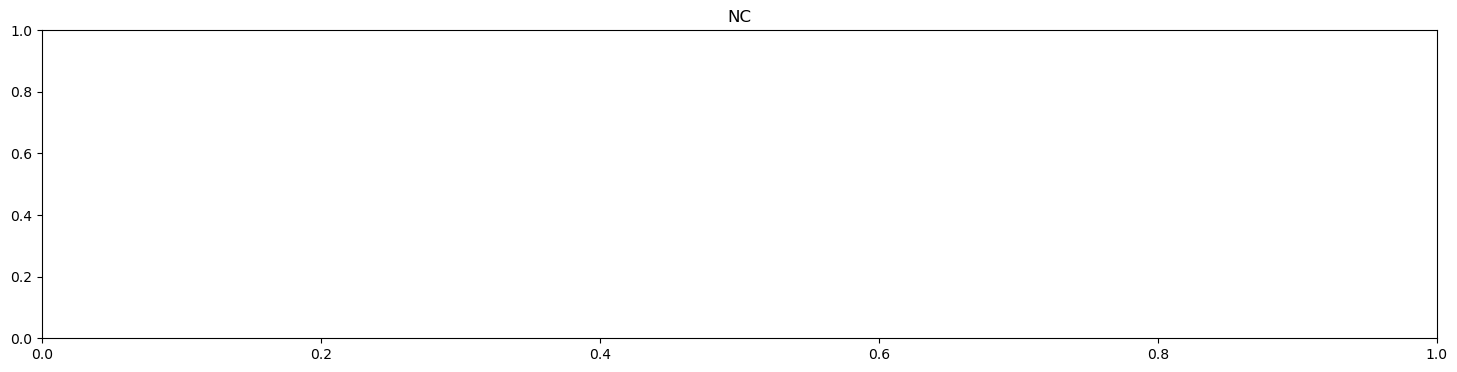

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
92
subgroup:  claudin-low


(177, 144)

(177,)

(20, 144)

(20,)

(177, 144)

(177,)

(20, 144)

(20,)

(177, 144)

(177,)

(20, 144)

(20,)

(177, 144)

(177,)

(20, 144)

(20,)

ComponentwiseGradientBoostingSurvivalAnalysis  \
train c-index                                          0.911   
test c-index                                           0.629   
AUC mean                                               0.592   

               GradientBoostingSurvivalAnalysis  RandomSurvivalForest  \
train c-index                             1.000                 0.935   
test c-index                              0.562                 0.730   
AUC mean                                  0.584                 0.750   

               ExtraSurvivalTrees  
train c-index               0.935  
test c-index                0.652  
AUC mean                    0.651

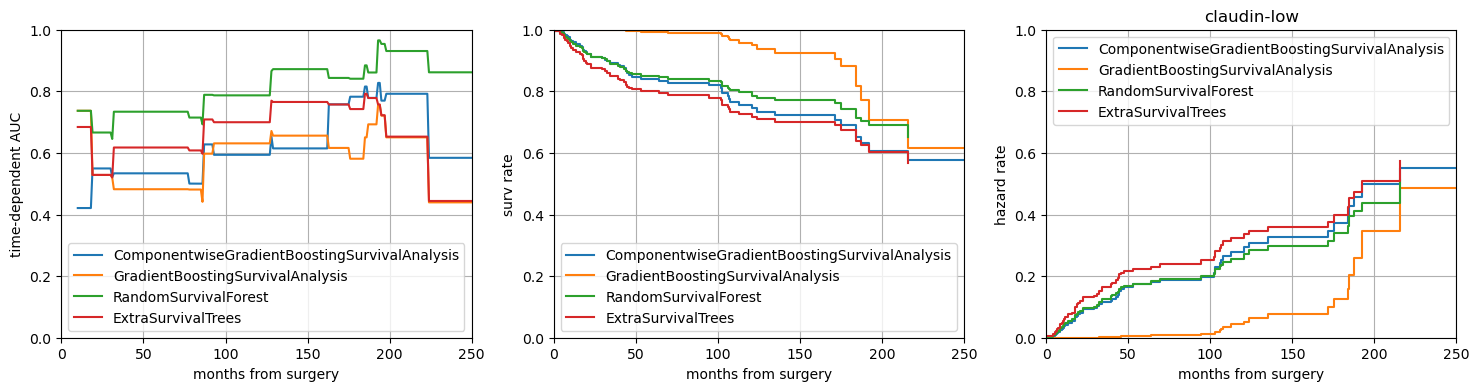

subgroup:  LumA


(605, 484)

(605,)

(68, 484)

(68,)

(605, 484)

(605,)

(68, 484)

(68,)

(605, 484)

(605,)

(68, 484)

(68,)

In [ ]:
for p in range(80, 95):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

In [43]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca80/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca80/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

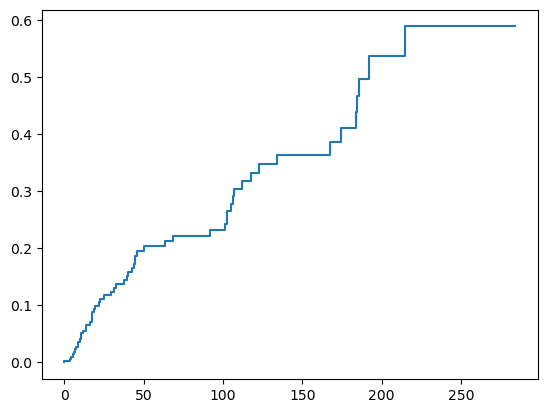

In [50]:
plt.step(
    pipe[-1].predict_cumulative_hazard_function(X)[1].x,
    pipe[-1].predict_cumulative_hazard_function(X)[1].y,
)